In [1]:
import tensorflow as tf
import keras 
import numpy as np
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.layers.normalization import BatchNormalization 
from keras import backend as K
from keras.layers import GaussianNoise, advanced_activations
from keras.engine.topology import Layer
from keras.legacy import interfaces
from keras.initializers import Zeros as kZeros
from keras.utils import multi_gpu_model
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from keras.callbacks import EarlyStopping
import sklearn
from sklearn.model_selection import train_test_split
plt.ylabel("Block error rate (BLER)")
plt.legend(["Relu (2,2)", "Leaky-Relu (2,2)", "Leaky-Relu (8,8)", \
            "Leaky-Relu (7,4)", "LR (2,2) new EbN0", "LR (8,8) new EbN0", \
            "LR (7,4) Rr=4/7"])
plt.show()
from sklearn.manifold import TSNE
# from tqdm import tqdm_notebook, tnrange
from time import time
import pickle

Using TensorFlow backend.


<Figure size 640x480 with 1 Axes>

In [2]:
# This is in a seperate box because it isn't running on the 
# AWS server. 
from tqdm import tqdm_notebook, tnrange

### Function Definitions

#### Most Likely Symbol Layer
I have intially done this with a normal function, however this hasn't been working with Keras. What I'm probably going to do next is make a custom layer for this as well and then add this. <br>
Not sure whether to use this in training though as using softwax may be a good way of training the model to give decisive decisions and it's also pretty useful for seeing the probabilities, and therefore confidence in it's decisions.

Numpy function

In [3]:
def most_likely_symbol(posterior_probs):
    row_indices = np.arange(posterior_probs.shape[0])
    col_indices = np.argmax(posterior_probs, axis=1)
    ret_arr = np.zeros(posterior_probs.shape)
    ret_arr[row_indices,col_indices] = 1
    return ret_arr

Keras backend (tensorflow) function

In [4]:
def most_likely(posterior_probs):
    max_vals = K.max(posterior_probs, axis=1, keepdims=True) 
    max_vals = K.cast(max_vals, 'float32')
    geT = K.greater_equal(posterior_probs, max_vals)
    return K.cast(geT, 'float32')

#### Custom most likely symbol layer
This layer need to, for all in-phase and quaternary outputs, pick the most likely symbol. <br>
I need to take in a softmax probability distribution for all the possible symbols (One hot encoded) and pick the one with the maximum likelyhood (value). Say $M$=2, then $S$ = {01,10} so $\hat{S}$ = {01,10}. This layer converts something that looks something like [0.63,0.27] to [1,0] <br>
**Note:** This layer should only be used in testing because gradients do not propogate through round functions. So this is a layer that should only be used at test time. 

In [5]:
class MostLikelySymbol(Layer):
    """Return the most likely symbol from a softmax input in the
    one hot encoded form.

    This layer is only active at test time as otherwise it would
    stop gradient propogation during training. Also it is useful
    to train with a softmax output to encourage a decisive 
    decision and because it means you can assess confidence.

    # Arguments
        None

    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.

    # Output shape
        Same shape as input.
    """

    @interfaces.legacy_gaussiannoise_support
    def __init__(self, **kwargs):
        super(MostLikelySymbol, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs, training=None):
        def most_likely():
            max_vals = K.max(inputs, axis=1, keepdims=True) 
            max_vals = K.cast(max_vals, 'float32')
            geT = K.greater_equal(inputs, max_vals)
            return K.cast(geT, 'float32')            
        return K.in_train_phase(inputs, most_likely, training=training)

    def get_config(self):
        config = {}
        base_config = super(MostLikelySymbol, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

#### Custom GaussianNoise layer
Ok, so the problem with the built in GaussianNoise layer is that it only adds noise at training time and not at testing time. So I've had a look in the source code and found how this is enacted. <br>
I'm now going to define my own custom layer which does exactly the same thing, but just adds the noise at both training time and testing time. <br>
I'm going to copy the source code from keras then just fiddle it so it does what I want.

In [6]:
class GaussianNoise2(Layer):
    """Apply additive zero-centered Gaussian noise at both traning
    and test time.

    This is useful to mitigate overfitting
    (you could see it as a form of random data augmentation).
    Gaussian Noise (GS) is a natural choice as corruption process
    for real valued inputs.

    Unlike the built in GaussianNoise regularisation layer it is 
    active at both training and test time. 

    # Arguments
        stddev: float, standard deviation of the noise distribution.

    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.

    # Output shape
        Same shape as input.
    """

    @interfaces.legacy_gaussiannoise_support
    def __init__(self, stddev, **kwargs):
        super(GaussianNoise2, self).__init__(**kwargs)
        self.supports_masking = True
        self.stddev = stddev

    def call(self, inputs, training=None):
        def noised():
            return inputs + K.random_normal(shape=K.shape(inputs),
                                            mean=0.,
                                            stddev=self.stddev)
        return K.in_train_phase(noised, noised, training=training)

    def get_config(self):
        config = {'stddev': self.stddev}
        base_config = super(GaussianNoise2, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [6]:
class ElementWiseMult(Layer):
    """Apply additive zero-centered Gaussian noise at both traning
    and test time.

    This is useful to mitigate overfitting
    (you could see it as a form of random data augmentation).
    Gaussian Noise (GS) is a natural choice as corruption process
    for real valued inputs.

    Unlike the built in GaussianNoise regularisation layer it is 
    active at both training and test time. 

    # Arguments
        stddev: float, standard deviation of the noise distribution.
        x: float, multiplication factor

    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.

    # Output shape
        Same shape as input.
    """

    def __init__(self, stddev, **kwargs):
        super(ElementWiseMult, self).__init__(**kwargs)
        self.supports_masking = True
        self.stddev = stddev

    def call(self, inputs, training=None):
        def noised():
            return inputs + K.random_normal(shape=K.shape(inputs),
                                            mean=0.,
                                            stddev=self.stddev)
        return K.in_train_phase(noised, noised, training=training)

    def get_config(self):
        config = {'stddev': self.stddev}
        base_config = super(ElementWiseMult, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [82]:
def make_model(M, R, sigma, activation_func):
    ### Initialising Parameters
    k = np.log2(M) # Number of bits needed to represent M 
                   # messages
    Nc = int(round(k/R)) # Number of bit being used to represent
                        # channel symbols being used 
                        # Number of complex channel uses
    Nr = Nc*2 # Number of real channel uses
    
    ### Defining Layers
    ## TRANSMITTER
    # This is my input placeholder
    input_message = Input(shape=(M,), name="input")
    # Encoded representation of the input
    # Relu layer to capture non-linearity
    tx1 = Dense(Nr,activation=activation_func, name="tx1")\
                (input_message)
    # Linear layer to give channel symbols not
    # clustered around 0 and 1.
    tx2 = Dense(Nr,activation=activation_func, name="tx2")(tx1)
    # Reshape it to complex channel symbols
    tx_complex = Lambda(lambda x : K.reshape(x, (-1,Nc,2)),
                       output_shape=(Nc,2), \
                        name="tx_reshape")(tx2)

    # Normalisation Layer
    tx_norm = Lambda(lambda x : K.l2_normalize(x,axis=2),
                     output_shape=(Nc,2), name="tx_norm")\
                        (tx_complex)
    tx_norm_scaled = Lambda(lambda x : K.tf.multiply(np.float32(np.sqrt(Nr)), x),
                      output_shape=(Nc,2), name="tx_norm_scaled")\
                        (tx_norm)

#     tx_norm = BatchNormalization(axis=2)(tx_complex)

    # Add Noise 
    noise = GaussianNoise2(sigma)(tx_norm_scaled)

    ## RECIEVER
    # Flatten the input
    noise_flat = Lambda(lambda x : K.reshape(x, (-1,Nr)),
                       output_shape=(Nr,),\
                        name="noise_flat")(noise)
    # Multiple Dense Layers
    # Dense relu layer to capture non linearity
    rx1 = Dense(M,activation=activation_func, name="rx1")\
                (noise_flat)
    # Dense layer with softmax activation
    rx_softmax = Dense(M,activation='softmax', \
                       name="rx_softmax")(rx1)
    # Select the symbols with the maximum probabilities
    ml_symbs = MostLikelySymbol()(rx_softmax)
    
    ###Defining the models
    autoencoder = Model(input_message, rx_softmax)
    ## Model the Tx and Rx seperately as well
    # Model the Tx
    transmitter = Model(input_message, tx_norm_scaled)
    # Model the Tx plus the noise
    channel_sym_with_noise = Model(input_message, noise)
    channel_symbol = Input(shape=(Nr,))
    # Take the last layer of the autoencoder model
    reciever_layers = autoencoder.layers[-2](channel_symbol)
    reciever_layers = autoencoder.layers[-1](reciever_layers)

    # Create a model of the reciever
    reciever = Model(channel_symbol, reciever_layers)
    autoencoder_symbs = Model(input_message,ml_symbs) 
    
    # Compile the model
    autoencoder.compile(loss='categorical_crossentropy',
                        optimizer="adam")
    return autoencoder, transmitter, reciever,\
            autoencoder_symbs, k, Nc, Nr

In [90]:
def make_non_complex_channel_model(k, Nr, sigma, activation_func):
    ### Initialising Parameters
    assert(round(k) == k)
    M = 2**k

    ### Defining Layers
    ## TRANSMITTER
    # This is my input placeholder
    input_message = Input(shape=(M,), name="input")
    # Encoded representation of the input
    # Relu layer to capture non-linearity
    tx1 = Dense(Nr,activation=activation_func, name="tx1")\
                (input_message)
    # Linear layer to give channel symbols not
    # clustered around 0 and 1.
    tx2 = Dense(Nr,activation=activation_func, name="tx2")(tx1)

    # Normalisation Layer
    tx_norm = Lambda(lambda x : K.l2_normalize(x,axis=1),
                     output_shape=(Nr,), name="tx_norm")\
                        (tx2)
    tx_norm_scaled = Lambda(lambda x : K.tf.multiply(np.float32(np.sqrt(Nr)), x),
                      output_shape=(Nr,), name="tx_norm_scaled")\
                        (tx_norm)
    
    # Add Noise 
    noise = GaussianNoise2(sigma)(tx_norm)

    ## RECIEVER
    # Multiple Dense Layers
    # Dense relu layer to capture non linearity
    rx1 = Dense(Nr,activation=activation_func, name="rx1")\
                (noise)
    # Dense layer with softmax activation
    rx_softmax = Dense(M,activation='softmax', \
                       name="rx_softmax")(rx1)
    # Select the symbols with the maximum probabilities
    ml_symbs = MostLikelySymbol()(rx_softmax)

    ###Defining the models
    autoencoder = Model(input_message, rx_softmax)
    ## Model the Tx and Rx seperately as well
    # Model the Tx
    transmitter = Model(input_message, tx_norm_scaled)
    # Model the Tx plus the noise
    channel_sym_with_noise = Model(input_message, noise)
    channel_symbol = Input(shape=(Nr,))
    # Take the last layer of the autoencoder model
    reciever_layers = autoencoder.layers[-2](channel_symbol)
    reciever_layers = autoencoder.layers[-1](reciever_layers)

    # Create a model of the reciever
    reciever = Model(channel_symbol, reciever_layers)
    autoencoder_symbs = Model(input_message,ml_symbs) 

    # Compile the model
    autoencoder.compile(loss='categorical_crossentropy',
                        optimizer="adam")
    return autoencoder, transmitter, channel_sym_with_noise, \
            reciever, autoencoder_symbs, k, Nr

In [9]:
def get_layer_shapes(start, end, num_steps):
    shapes = [start]
    diff = (end-start)/(num_steps-1)
    # Always start with a full dense layer
    for i in range(1,num_steps):
        shapes.append(int(start + i*diff))
    return shapes

In [10]:
def make_complex_n_layer_lr_tanh_tapering_model(M, R, sigma, \
                                                hl_activation_func, \
                                                ol_activation_func, \
                                                num_layers):
    ### Initialising Parameters
    k = np.log2(M) # Number of bits needed to represent M 
                   # messages
    Nc = int(round(k/R)) # Number of bit being used to represent
                        # channel symbols being used 
                        # Number of complex channel uses
    Nr = Nc*2 # Number of real channel uses

    ### Defining Layers
    ## TRANSMITTER
    tx_shapes = get_layer_shapes(M, Nr, num_layers)
    input_message = Input(shape=(M,), name="input")
    # Hidden Tx layers
    tx1 = Dense(tx_shapes[0],activation=hl_activation_func, \
                name="tx1")(input_message)
    for i in range(1,num_layers-1):
        tx1 = Dense(tx_shapes[i],activation=hl_activation_func, \
                    name=("tx"+str(i+1)))(tx1)
    # Final layer with a different activation function to capture non
    # linearity
    tx_n = Dense(tx_shapes[-1],activation=ol_activation_func, \
                 name=("tx"+str(num_layers)))(tx1)
    # Reshape it to complex channel symbols
    tx_complex = Lambda(lambda x : K.reshape(x, (-1,Nc,2)),
                       output_shape=(Nc,2), \
                        name="tx_reshape")(tx_n)

    # Normalisation Layer
    tx_norm = Lambda(lambda x : K.l2_normalize(x,axis=2),
                     output_shape=(Nc,2), name="tx_norm")\
                        (tx_complex)

    # Add Noise 
    noise = GaussianNoise2(sigma)(tx_norm)

    ## RECIEVER
    # Flatten the input
    noise_flat = Lambda(lambda x : K.reshape(x, (-1,Nr)),
                       output_shape=(Nr,),\
                        name="noise_flat")(noise)
    # First layer with the different activation function
    # to capture non-linearity and for symmetry with the 
    # transmitter.
    rx1 = Dense(tx_shapes[-2],activation=ol_activation_func, name="rx1")\
                (noise_flat)
    # Hidden Rx Layers
    if(num_layers >= 3):
        layer_ind = -3
    else:
        layer_ind = -2
    rx_i = Dense(tx_shapes[layer_ind],activation=hl_activation_func, \
                name="rx2")(rx1)
    for i in range(2,num_layers):
        ind = max(0,num_layers - 2 - i)
        rx_i = Dense(tx_shapes[ind],activation=hl_activation_func, \
                    name=("rx"+str(i+1)))(rx_i)
    # Dense layer with softmax activation
    rx_softmax = Dense(tx_shapes[0],activation='softmax', \
                       name="rx_softmax")(rx_i)
    
    # Select the symbols with the maximum probabilities
    ml_symbs = MostLikelySymbol()(rx_softmax)
    
    ###Defining the models
    autoencoder = Model(input_message, rx_softmax)
    ## Model the Tx and Rx seperately as well
    # Model the Tx
    transmitter = Model(input_message, tx_norm)
    # Model the Tx plus the noise
    channel_sym_with_noise = Model(input_message, noise)
    channel_symbol = Input(shape=(Nr,))
    # Take the last layer of the autoencoder model
    reciever_layers = autoencoder.layers[-(num_layers+1)](channel_symbol)
    for i in range(num_layers):
        reciever_layers = autoencoder.layers[-(num_layers-i)](reciever_layers)

    # Create a model of the reciever
    reciever = Model(channel_symbol, reciever_layers)
    autoencoder_symbs = Model(input_message,ml_symbs) 
    
    # Compile the model
    autoencoder.compile(loss='categorical_crossentropy',
                        optimizer="adam")
    return autoencoder, transmitter, reciever,\
            autoencoder_symbs, k, Nc, Nr

In [11]:
def plot_constellation_diagram(valid_set, transmitter, name):
    channel_symbols = transmitter.predict(valid_set)
    fig, ax = plt.subplots()
    ax.plot(channel_symbols[:,:,0], channel_symbols[:,:,1],\
            'k.')
#     ax.set_title("CS Constellation Diagram: "+name)
    ax.set_aspect('equal', 'box')
    plt.xticks([-2,-1,0,1,2])
    plt.yticks([-2,-1,0,1,2])
    plt.grid(True)

In [12]:
def get_block_error_rate(test_data, pred_symbs):
    errors = (test_data != pred_symbs)
    block_errors = errors.any(axis=1)
    return block_errors.sum()/block_errors.shape[0]

In [13]:
def get_noise_sigma(Eb_N0_db, Rr=None, Rc=None):
    assert(not((Rr == None)&(Rc == None)))
    if(Rr == None):
        Rr = Rc/2.
    Eb_N0 = 10.**(Eb_N0_db/10.)
    return np.sqrt(1./(2.*Rr*Eb_N0))

In [14]:
def get_noise_sigma_k(Eb_N0_db, k):
    Eb_N0 = 10.**(Eb_N0_db/10.)
    return np.sqrt(1./(2.*k*Eb_N0))

In [15]:
def get_data_set(M, total_size):
    t0 = time()
    all_one_hot_messages = np.diag(np.ones(M))
    perc_train = 0.75
    perc_valid = 0.1

    ## Making Data Set
    multiple = total_size//M
    diff = total_size - (multiple * M)

    ## Get quotient 
    ## Converted the array into a list because it is significantly
    ## faster
    l = []
    all_one_hot_messages_lst = all_one_hot_messages.tolist()
    for mult in range(multiple):
        for i in range(M):
            l.append([all_one_hot_messages_lst[i]])
    data = np.concatenate(l)

    # Add remainder
    random_inds = np.random.choice(np.arange(M),size=diff, replace=False)
    extra_rows = all_one_hot_messages[random_inds,:]
    data = np.concatenate((data, extra_rows), axis=0)
    np.random.shuffle(data)
    file_path = "./data/data"+str(M)+".npy"
    np.save(file_path, data)
    print(f"Took {time() - t0}s")
    return data, file_path, all_one_hot_messages

#### BKSP functions

In [16]:
def bpsk_encode(int_bit):
    if(int_bit == 0):
        return -1
    elif(int_bit == 1):
        return 1
    else:
        assert(False)
bpsk_encode_vec = np.vectorize(bpsk_encode)

In [17]:
def bpsk_decode(float_bit):
    if(float_bit <= 0.):
        return 0
    elif(float_bit >0.):
        return 1
    else:
        assert(False)
bpsk_decode_vec = np.vectorize(bpsk_decode)

#### Hamming 7,4 functions

In [18]:
# Essential matrices for Hamming encoding
G = np.array(\
             [[1,1,0,1],
             [1,0,1,1],
             [1,0,0,0],
             [0,1,1,1],
             [0,1,0,0],
             [0,0,1,0],
             [0,0,0,1]])
H = np.array(\
            [[1,0,1,0,1,0,1],
            [0,1,1,0,0,1,1],
            [0,0,0,1,1,1,1]])
p = np.array([[1],
             [0],
             [1],
             [1]])
R_ham = np.array([[0,0,1,0,0,0,0],
                 [0,0,0,0,1,0,0],
                 [0,0,0,0,0,1,0],
                 [0,0,0,0,0,0,1]])

In [19]:
def make_lsb(dec_num):
    return float(int(bin(int(dec_num))[-1]))
# vectorising the function made it about 40% faster,
# not incredible but makes a small difference
make_lsb_vec = np.vectorize(make_lsb)

In [20]:
def get_error_ind(arr_col):
    return 4*arr_col[0] + 2*arr_col[1] + arr_col[2] - 1

In [21]:
def do_error_correction(data, error_inds):
    for i in range(data.shape[1]):
        if(error_inds[i] >= 0):
            data[int(error_inds[i]),i] = float(np.logical_not(data[int(error_inds[i]),i]))

In [22]:
def hamming_7_4_encode(test_data, G):
    test_data_enc = np.matmul(G,test_data.T)
    return make_lsb_vec(test_data_enc)   

In [23]:
def hamming_7_4_decode_and_correct(received, H, R):
    # Round values to [0,1]
    r_round = np.where(received > 0.5, 1, 0)
    # Do parity check
    parity_check = np.matmul(H,r_round)
    parity_check = make_lsb_vec(parity_check)   
    # Get error bit indices
    error_inds = np.apply_along_axis(get_error_ind, 0,\
                                     parity_check)
    # Do error correction
    do_error_correction(r_round, error_inds)
    # Decode corrected message
    return np.matmul(R,r_round).T

In [24]:
def plot_tSNE_channel_symbols(channel_symbols, dot_size = None):
    tSNE_channel_symbols = TSNE(n_components=2).fit_transform(channel_symbols)
    # Normalise the dimensionally reduced channel symbols
    no_mean = tSNE_channel_symbols - np.mean(tSNE_channel_symbols, axis=0)
    avg_power = np.mean(np.sqrt(np.sum(np.square(no_mean),axis=1)))
    normalised = no_mean/avg_power

    fig, ax = plt.subplots()
    if(dot_size == None):
        ax.plot(normalised[:,0], normalised[:,1],\
                'k.')
    else:
        ax.plot(normalised[:,0], normalised[:,1],\
                'k.', markersize=1)
    ax.set_aspect('equal', 'box')
    plt.xticks([-2,-1,0,1,2])
    plt.yticks([-2,-1,0,1,2])
    plt.grid(True)

In [25]:
def plot_tSNE_constellation_diagram(valid_set, transmitter, dot_size = None):
    channel_symbols = transmitter.predict(valid_set)
    plot_tSNE_channel_symbols(channel_symbols, dot_size)

In [26]:
def plot_noisy_tSNE_constellation_diagram(valid_set, transmitter, num_iters, dot_size = None):
    all_symbs = np.empty([0,7])
    for i in range(num_iters):
        channel_symbols = channel_sym_with_noise7_4.predict(all_one_hot_messages16)
        all_symbs = np.vstack([channel_symbols,all_symbs])    
    plot_tSNE_channel_symbols(all_symbs, dot_size)

In [27]:
def get_noise_bler(M, R, Eb_N0, weights_file_path, test_data, act_f):
    ## Get noise std_dev 
    noise_std = get_noise_sigma(Eb_N0, Rc=R)   
    ## Make new model with loaded weights
    autoencoder_tmp, _, _, autoencoder_symbs_tmp, \
        _, _, _ = make_model(M, R, noise_std, act_f)
    autoencoder_tmp.load_weights(weights_file_path, by_name=True)    
    ## Check Accuracy on test set
    pred_symbs = autoencoder_symbs_tmp.predict(test_data)
    return get_block_error_rate(test_data, pred_symbs)

In [28]:
def get_noise_bler_k(M, R, Eb_N0, weights_file_path, test_data, act_f):
    ## Get noise std_dev 
    k = 2*np.log2(M)/R
    noise_std = get_noise_sigma_k(Eb_N0, k)   
    ## Make new model with loaded weights
    autoencoder_tmp, _, _, autoencoder_symbs_tmp, \
        _, _, _ = make_model(M, R, noise_std, act_f)
    autoencoder_tmp.load_weights(weights_file_path, by_name=True)    
    ## Check Accuracy on test set
    pred_symbs = autoencoder_symbs_tmp.predict(test_data)
    return get_block_error_rate(test_data, pred_symbs)

In [29]:
def get_non_complex_noise_bler(k, Nr, Eb_N0, weights_file_path, test_data, act_f):
    ## Get noise std_dev 
    noise_std = get_noise_sigma(Eb_N0, Rr=(k/Nr))   
    ## Make new model with loaded weights
    autoencoder_tmp, _, _, _, autoencoder_symbs_tmp, _, _ \
        = make_non_complex_channel_model(k, Nr, noise_std, act_f)
    autoencoder_tmp.load_weights(weights_file_path, by_name=True)    
    ## Check Accuracy on test set
    pred_symbs = autoencoder_symbs_tmp.predict(test_data)
    return get_block_error_rate(test_data, pred_symbs)

In [30]:
def get_non_complex_noise_bler_k(k, Nr, Eb_N0, weights_file_path, test_data, act_f):
    ## Get noise std_dev 
    noise_std = get_noise_sigma_k(Eb_N0, k)   
    ## Make new model with loaded weights
    autoencoder_tmp, _, _, _, autoencoder_symbs_tmp, _, _ \
        = make_non_complex_channel_model(k, Nr, noise_std, act_f)
    autoencoder_tmp.load_weights(weights_file_path, by_name=True)    
    ## Check Accuracy on test set
    pred_symbs = autoencoder_symbs_tmp.predict(test_data)
    return get_block_error_rate(test_data, pred_symbs)

In [31]:
def get_complex_tapered_noise_bler(M, R, Eb_N0, weights_file_path, \
                                   test_data, hl_activation_func, \
                                   ol_activation_func, num_layers):
    ## Get noise std_dev 
    noise_std = get_noise_sigma(Eb_N0, Rc=R)   
    ## Make new model with loaded weights
    autoencoder8_8_tap_nl, _, _, autoencoder_symbs8_8_tap_nl, \
        _, _, _ \
        = make_complex_n_layer_lr_tanh_tapering_model(M, R, noise_std, \
                                                      hl_activation_func, \
                                                      ol_activation_func, \
                                                      num_layers)    
    autoencoder8_8_tap_nl.load_weights(weights_file_path, by_name=True)    
    ## Check Accuracy on test set
    pred_symbs = autoencoder_symbs8_8_tap_nl.predict(test_data)
    return get_block_error_rate(test_data, pred_symbs)

In [32]:
def bpsk_get_bler(std, test_data):
    bpsk_encoded = bpsk_encode_vec(test_data)
    # Add AWGN noise
    noise = std * np.random.randn(bpsk_encoded.shape[0],\
                                  bpsk_encoded.shape[1])
    received = bpsk_encoded + noise
    bpsk_decoded = bpsk_decode_vec(received)

    # Get Block error rate
    return get_block_error_rate(test_data, bpsk_decoded)

### Loading results

In [33]:
leaky_relu_autoencoder_2_2_bler = np.load('./key_results/leaky_relu_autoencoder_2_2_bler.npy')
leaky_relu_autoencoder_8_8_bler = np.load('./key_results/leaky_relu_autoencoder_8_8_bler.npy')
leaky_relu_autoencoder_7_4_bler = np.load('./key_results/leaky_relu_autoencoder_7_4_bler.npy')

leaky_relu_autoencoder_2_2_bler_k = np.load('./key_results/leaky_relu_autoencoder_2_2_bler_k.npy')
leaky_relu_autoencoder_8_8_bler_k = np.load('./key_results/leaky_relu_autoencoder_8_8_bler_k.npy')
leaky_relu_autoencoder_7_4_bler_k = np.load('./key_results/leaky_relu_autoencoder_7_4_bler_k.npy')

leaky_relu_autoencoder_7_4_bler_Rr4_7 = np.load('./key_results/leaky_relu_autoencoder_7_4_bler_Rr4_7.npy')
leaky_relu_autoencoder_7_4_bler0_8866_Rr4_7 = np.load('./key_results/leaky_relu_autoencoder_7_4_bler0_8866_Rr4_7.npy')
leaky_relu_autoencoder_8_8_bler_2l_0_1763Rr1 = np.load('./key_results/leaky_relu_autoencoder_8_8_bler_2l_0_1763Rr1.npy')
leaky_relu_autoencoder_2_2_bler_0_0683_Rr1 = np.load('./key_results/leaky_relu_autoencoder_2_2_bler_0_0683_Rr1.npy')


autoencoder8_8_tap_2l_bler = np.load('./key_results/autoencoder8_8_tap_2l_bler.npy')
autoencoder8_8_tap_3l_bler = np.load('./key_results/autoencoder8_8_tap_3l_bler.npy')
autoencoder8_8_tap_4l_bler = np.load('./key_results/autoencoder8_8_tap_4l_bler.npy')
autoencoder8_8_tap_5l_bler = np.load('./key_results/autoencoder8_8_tap_5l_bler.npy')

autoencoder_2_2_bler = np.load('./key_results/autoencoder_2_2_bler.npy')


bpsk_2_2_bler = np.load('./key_results/bpsk_2_2_bler.npy')
bpsk_4_4_bler = np.load('./key_results/bpsk_4_4_bler.npy')
bpsk_8_8_bler = np.load('./key_results/bpsk_8_8_bler.npy')

bpsk_2_2_bler_Rr1 = np.load('./key_results/bpsk_2_2_bler_Rr1.npy')
bpsk_4_4_bler_Rr1 = np.load('./key_results/bpsk_4_4_bler_Rr1.npy')
bpsk_8_8_bler_Rr1 = np.load('./key_results/bpsk_8_8_bler_Rr1.npy')

hamming_7_4_HD_bler = np.load('./key_results/hamming_7_4_HD_bler.npy')
hamming_7_4_HD_bler_Rr4_7 = np.load('./key_results/hamming_7_4_HD_bler_Rr4_7.npy')

bpsk_4_4_bler = np.load('./key_results/bpsk_4_4_bler.npy')
bpsk_4_4_bler_Rr1 = np.load('./key_results/bpsk_4_4_bler_Rr1.npy')
hamming_7_4_HD_bler = np.load('./key_results/hamming_7_4_HD_bler.npy')
hamming_7_4_HD_bler_Rr4_7 = np.load('./key_results/hamming_7_4_HD_bler_Rr4_7.npy')
leaky_relu_autoencoder_7_4_bler = np.load('./key_results/leaky_relu_autoencoder_7_4_bler.npy')

bpsk_2_2_bler = np.load('./key_results/bpsk_2_2_bler.npy')
bpsk_8_8_bler = np.load('./key_results/bpsk_8_8_bler.npy')
bpsk_2_2_bler_Rr1 = np.load('./key_results/bpsk_2_2_bler_Rr1.npy')
bpsk_8_8_bler_Rr1 = np.load('./key_results/bpsk_8_8_bler_Rr1.npy')
leaky_relu_autoencoder_2_2_bler = np.load('./key_results/leaky_relu_autoencoder_2_2_bler.npy')
leaky_relu_autoencoder_8_8_bler = np.load('./key_results/leaky_relu_autoencoder_8_8_bler.npy')

lr_autoencoder_2_2_bler_0_0047_Rr1_scaled = np.load('./key_results/lr_autoencoder_2_2_bler_0_0047_Rr1_scaled.npy')

### To do list
- DONE/Work out how to add noise even at test time
- DONE/Make most likely symbol layer
- DONE/Turn all the inputs and outputs into complex numbers 
- DONE/Fix the normalisation layer, currently for M=2 and N=1 I'm just getting 0 and 1, whereas you'd expect -c and +c. Note this needs to take into account the IQ pairs.
- DONE/Make BPSK encoding
- DONE/Make Hamming encoding 
- DONE/Get a graph comparing Hamming encoding, BPSK and an autoencoder
- Sweep across different activation functions to see what error and constellation diagrams they get.
- Sweep across different batch sizes to see what gives a better model
- Sweep across different training noise_stds to find the best for training
- Graph didn't look great to try out a (7,4) autoencoder
- Implement t-SNE so I can get constellation diagrams for the cases with n>2.

- try out different activation functions 
- try out different numbers of layers
- Try out using different activation functions for two halfs of a given layer. This is called Inception networks. 
- first consider without dropout


#### Work Log
06/02/2019
- Changed the normalisation to use the BatchNormalization function <br>

07/02/2019
- Changed the batch size, increased the data size and changed the axis along which BatchRegularization was done
- The results were very inconsistent, reading suggested this might be to do with the ReLu activation function giving dependence on initialisation values due to neuron death.
- Consequently tried a leaky-relu activation function
- Found a bug that one layer was being bypassed
- Switched back to original regularisation layer but over a different axis.
- Decided it makes sense to use an l2 regulariser as that reflects a transmitter with a constant power budget
- Named all layers so that weights could be loaded from one layer into another
- Plotted BLER graph for (2,2) case
- Started implementing hamming encoding

08/02/2019
- Changed the constellation diagram plot to match the O'Shea paper's format.

13/02/2019
- Added hard decision Hamming encoding and decoding
- Added BPSK encoding and decoding
- Compared Autoencoder (2,2), BPSK (4,4) and Hamming (7,4) hard decision one one graph

14/02/2019
- Compared four activation functions to see which one had the best verification error.

6-12/05/2019
- Compared the leaky-relu activation function against the tanh activation function and found it marginally outperformed it, therefore proceeded from then on with the tanh activation function.
- Made a (7,4) autoencoder model and compared it's performance against the others.
- Used t-SNE to get constellation diagrams for the (7,4) model, both with and without noise. 
- Found the t-SNE method of dimensionality reduction introduces some randomness and so the constellation diagram is slightly different each time.
- Had to normalise the outputs of the t-SNE dimensionality reduction to zero-mean and unit power, despite it's input being stationary satisfying the afore-mentioned conditions.
- Developed (2,2) and (8,8) BPSK, compared these against each other and against the other encoding methods.
- Produced Figure's 3a and 3b from the O'Shea paper, however the ordering of the capabilities of the encoding methods is not in the right order. The (8,8) and (7,4) autoencoders underperform, and BPSK over performs.
    - The ordering is odd, I would expect it to be from best to worst: (7,4), (2,2), (8,8). But it is actually currently: (2,2), (7,4), (8,8).
    - I have yet to find out what Hamming Maximum Likelihood Decision is.
- Decided that the reason the (8,8) and (7,4) models might be underperforming may be because of a lack of layers, so tried increasing the number of layers and making the final layer of each block have a tanh activation funciton to try and capture non-linearity.

13/05/2019
- I realised that my 8_8 was actually and 8_4, so I've adjusted that and I'm retraining the model to see what kind of validation_loss it gets. The best 8_4 accuracy found was 1.06, an initial re-training with no tapering gave a val_loss of 0.0750.

14/05/2019
- Trained models with 2,3,4 and 5 layers and tapered layer widths.
    - Yet to test their performances, they're still training.
- Realised that the (7,4) model was being unfairly normalised. The (8,8) and (2,2) models are normalised so that they have unit power for each complex channel symbol. Whereas the (7,4) model is being normalised so that it has unit power for all 7 bits. So I need to multiply all the values post normalisation by sqrt(3.5) to make it even.
    - I need to check if this applies to the BPSK stuff as well.
    
20/05/2019
- Switched to and AWS notebook so that it trained faster.
- Retrained all models with the sigmas specified to the correct Rr
- Adapt the bpsk_get_bler function so that the transmit power is the same for all of them
- Added dropout regulation
- Added Hamming MLD
- Moved onto looking into the reinforcement learning

21/05/2019
- Had a meeting with Morteza Varasteh. The upshots are listed below:
    - Batch normalise for the (7,4) case
    - For BLER convert incorrect symbols anyway then find the BER
    - Hamming MLD is just calculate the probability that a given received set of seven channel uses could have come from any of the transmitted symbols, then pick the symbol with the highest posterior probability.
    - Set the power normalisation to be n for each row, not 1, that way on average each transmitter bit has 1 unit of power.
- First I set the average power of the complex models to be 1 per bit.
    - Done for (2,2) -> success, (7,4) no success
- Next I checked the definition of BLER, I'm pretty sure that my previous definition of BLER. It's defined here:
    - https://www.etsi.org/deliver/etsi_en/301900_301999/30190808/01.01.01_30/en_30190808v010101v.pdf
    - "**BLER (BLock Error Ratio)**: ratio of blocks received in error to the total number of received blocks, where a block is defined as received in error if the error detection functions in the receiver indicate an error as the result of the Block Check Sequence (BCS)"

### IQ complex number general notes
The symbols at each end are not in IQ form, but the channel symbols need to be in IQ form. <br>
Potentially I could do this purely by increasing the number of nodes in the middle. But I'm not sure how I specify the pair relationships.<br>
Currently reading about this in EE3-03 Communication System, Lecutre 2.d "Constellation Diagram & Line Codes...", slide 15.

### Chat with M.Varasteh
- first consider without dropout
- try out different activation functions 
- try out different numbers of layers
- Try out using different activation functions for two halfs of a given layer. This is called Inception networks. 
- You can't do this with standard code out of tf and keras, will have to write custom code.
- Tanh is usually good because it is linear for small inputs, relu is better for capturing non-linearity 
- Inception learning allows the optimisation to pick the activation function
- Can have a custom activation function which picks is a weighted sum of say relu and tanh.


### Hyperparameters I should look at
- Activation functions:
    - Tanh - ~linear for small inputs 
    - Relu - captures non linearity well
    - Sigmoid, softmax, linear
    - Inception learning
- Loss functions
    - MSE, categorical cross entropy
- Regularisation
    - Dropout
    - Normalisation constraints:
        - $\lVert x\rVert _2^2 \leq n$, $\lvert x_i \rvert \leq 1$, $E[\lvert x_i\rvert ^2] \lt 1$
- Structure
    - Try making it 2d in the first layer vs in the last layer
    - Number of layers

### Noise Ideas
- In O'Shea et al they used AWGN with variance = (2*R*E_b/N_0)^-1
Later I'd like to try
    - Slow and Fast Rayleigh fading 
    - Try all the types of stuff found in the textbook

In [34]:
#def Noise Layer
# Add noise, probably start with AWGN
# Later try
# - Slow and Fast Rayleigh fading 
# - Try all the types of stuff found in the textbook
# x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 

In [35]:
#def Reciever
# Multiple dense layers
# Dense layer with softmax activation
# This gives an array of posterior probabilities, so then
# pick the maximum of these posterior probabilities.

## Getting started
- Start with M = 2 (k = 1), n = 1 (so R = 1), try and learn BPSK
- Let's learn it, have a look at the constellation diagram, then try some bigger M's

Testing the two most_likely_symbol functions

In [36]:
pps2 = np.random.rand(5,3)
totals = np.expand_dims(np.sum(pps2, axis=1), axis=1)
pps2 = np.divide(pps2,totals)
pps2 = np.round(pps2,2)
ppsT = K.constant(pps2)
sess = tf.Session()
with sess.as_default():
    ppsT.eval(session=sess)
ppsT.eval(session=sess)

array([[0.28, 0.42, 0.3 ],
       [0.38, 0.44, 0.17],
       [0.39, 0.07, 0.54],
       [0.37, 0.38, 0.25],
       [0.44, 0.28, 0.29]], dtype=float32)

In [37]:
most_likely(ppsT).eval(session=sess)

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [38]:
most_likely_symbol(pps2)

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]])

### Making a model
I'm thinking that to express every input as a complex number (in-phase and quaterature) parts, I could run two NN's in parallel, but then it wouldn't be able to learn any links between ther two. <br>
Alternatively make it twice as wide, so each input goes in in pairs, and select the most likely symbols from even indices and odd indices seperately, output of that is my complex output.

The O'Shea paper trained their models $E_b/N_o = 7db$, so the training variance is calculated below using the formula from the paper

In [83]:
M = 4 # Number of one hot encoded messages
R = 2 # R = k/n

sigma = get_noise_sigma(7, Rr=1)
print("sigma = ",sigma)
act_f = keras.layers.advanced_activations.LeakyReLU()
act_f.__name__ = 'leakyrelu'
autoencoder2_2, transmitter2_2, reciever2_2, autoencoder_symbs2_2,\
    k2_2, Nc2_2, Nr2_2 = make_model(M, R, sigma, act_f)

sigma =  0.31585299705471215


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [40]:
M = 16 # Number of one hot encoded messages
R = 4 # R = k/n_r

sigma = get_noise_sigma(7, Rc=R)
print("sigma = ",sigma)
autoencoder2_4, transmitter2_4, reciever2_4, autoencoder_symbs2_4,\
    k2_4, Nc2_4, Nr2_4 = make_model(M, R, sigma, act_f)

sigma =  0.22334179607548157


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [41]:
M = 2**8 # Number of one hot encoded messages
R = 2 # R = k/n_r

sigma = get_noise_sigma(7, Rc=R)
print("sigma = ",sigma)
autoencoder8_8, transmitter8_8, reciever8_8, autoencoder_symbs8_8,\
    k8_8, Nc8_8, Nr8_8 = make_model(M, R, sigma, act_f)

sigma =  0.31585299705471215


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [91]:
k = 4 # Number of one hot encoded messages
Nr = 7 # R = k/n_r

sigma = get_noise_sigma(7, Rr=(k/Nr))
print("sigma = ",sigma)
autoencoder7_4, transmitter7_4, channel_sym_with_noise7_4, reciever7_4, \
    autoencoder_symbs7_4, k7_4, Nr7_4 \
    = make_non_complex_channel_model(k, Nr, sigma, act_f)

sigma =  0.4178342405305925


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [43]:
# # (8,8)
# M = 2**8 # Number of one hot encoded messages
# R = 2 # R = k/n_r
# sigma = get_noise_sigma(7, Rc=R)
# hl_activation_func = keras.layers.advanced_activations.LeakyReLU()
# hl_activation_func.__name__ = 'leakyrelu'
# ol_activation_func = "tanh"
# num_layers = 3

# autoencoder8_8_tap, transmitter8_8_tap, reciever8_8_tap, \
#     autoencoder_symbs8_8_tap, k8_8_tap, Nc8_8_tap, Nr8_8_tap \
#     = make_complex_n_layer_lr_tanh_tapering_model(M, R, sigma, \
#                                                   hl_activation_func, \
#                                                   ol_activation_func, \
#                                                   num_layers)

In [44]:
# (8,8)
M = 2**8 # Number of one hot encoded messages
R = 2 # R = k/n_r
sigma = get_noise_sigma(7, Rc=R)
hl_activation_func = keras.layers.advanced_activations.LeakyReLU()
hl_activation_func.__name__ = 'leakyrelu'
ol_activation_func = "tanh"
num_layers = 2

autoencoder8_8_tap_2l, transmitter8_8_tap_2l, reciever8_8_tap_2l, \
    autoencoder_symbs8_8_tap_2l, k8_8_tap_2l, Nc8_8_tap_2l, Nr8_8_tap_2l \
    = make_complex_n_layer_lr_tanh_tapering_model(M, R, sigma, \
                                                  hl_activation_func, \
                                                  ol_activation_func, \
                                                  num_layers)

/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [45]:
# (8,8)
M = 2**8 # Number of one hot encoded messages
R = 2 # R = k/n_r
sigma = get_noise_sigma(7, Rc=R)
hl_activation_func = keras.layers.advanced_activations.LeakyReLU()
hl_activation_func.__name__ = 'leakyrelu'
ol_activation_func = "tanh"
num_layers = 3

autoencoder8_8_tap_3l, transmitter8_8_tap_3l, reciever8_8_tap_3l, \
    autoencoder_symbs8_8_tap_3l, k8_8_tap_3l, Nc8_8_tap_3l, Nr8_8_tap_3l \
    = make_complex_n_layer_lr_tanh_tapering_model(M, R, sigma, \
                                                  hl_activation_func, \
                                                  ol_activation_func, \
                                                  num_layers)

/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activatio

In [46]:
# (8,8)
M = 2**8 # Number of one hot encoded messages
R = 2 # R = k/n_r
sigma = get_noise_sigma(7, Rc=R)
hl_activation_func = keras.layers.advanced_activations.LeakyReLU()
hl_activation_func.__name__ = 'leakyrelu'
ol_activation_func = "tanh"
num_layers = 4

autoencoder8_8_tap_4l, transmitter8_8_tap_4l, reciever8_8_tap_4l, \
    autoencoder_symbs8_8_tap_4l, k8_8_tap_4l, Nc8_8_tap_4l, Nr8_8_tap_4l \
    = make_complex_n_layer_lr_tanh_tapering_model(M, R, sigma, \
                                                  hl_activation_func, \
                                                  ol_activation_func, \
                                                  num_layers)

/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activatio

In [47]:
# (8,8)
M = 2**8 # Number of one hot encoded messages
R = 2 # R = k/n_r
sigma = get_noise_sigma(7, Rc=R)
hl_activation_func = keras.layers.advanced_activations.LeakyReLU()
hl_activation_func.__name__ = 'leakyrelu'
ol_activation_func = "tanh"
num_layers = 5

autoencoder8_8_tap_5l, transmitter8_8_tap_5l, reciever8_8_tap_5l, \
    autoencoder_symbs8_8_tap_5l, k8_8_tap_5l, Nc8_8_tap_5l, Nr8_8_tap_5l \
    = make_complex_n_layer_lr_tanh_tapering_model(M, R, sigma, \
                                                  hl_activation_func, \
                                                  ol_activation_func, \
                                                  num_layers)

/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activatio

##### Keras multiple GPU models

In [48]:
# # Replicates `model` on 8 GPUs.
# # This assumes that your machine has 8 available GPUs.
# parallel_model = multi_gpu_model(model, gpus=8)
# parallel_model.compile(loss='categorical_crossentropy',
#                        optimizer='rmsprop')

### Make a toy data set

In [49]:
# # Get a set of data for a particular M
# all_one_hot_messages = np.diag(np.ones(M))
# print("all_one_hot_messages.shape = ",all_one_hot_messages.shape)
# #total_size = 10,000,000 (10M)
# total_size = 10000000
# all_one_hot_messages4 = np.diag(np.ones(4))
# all_one_hot_messages16 = np.diag(np.ones(16))
# all_one_hot_messages256 = np.diag(np.ones(256))


# # Automatically saves the data for m to a filepath of
# # './data/data${M}.npy'
# t0 = time()
# func_data4, file_path4, all_one_hot_messages4 = get_data_set(4, total_size)
# t1 = time()
# print(f"Finished 4 in {t1-t0}s")
# func_data16, file_path16, all_one_hot_messages16 = get_data_set(16, total_size)
# t2 = time()
# print(f"Finished 16 in {t2-t1}s")
# func_data256, file_path256, all_one_hot_messages256 = get_data_set(256, total_size)
# print(f"Finished 256 in {time()-t2}s")

# # Don't use this function unless it's for a new M, just
# # load the data you have calculated other times.
# # This makes results more comparible and saves time.

In [71]:
# Load the data calculated from previous runs
all_one_hot_messages4 = np.diag(np.ones(4))
all_one_hot_messages16 = np.diag(np.ones(16))
all_one_hot_messages256 = np.diag(np.ones(256))

data256 = np.load('./data/data256.npy')
data16 = np.load('./data/data16.npy')
data4 = np.load('./data/data4.npy')

In [51]:
# Splitting into training, testing and validation sets
train_data4, test_data4 = train_test_split(data4, \
                                         train_size=0.8)
train_data4, valid_data4 = train_test_split(train_data4, \
                                         train_size=0.9)
print(f"train_data4.shape = {train_data4.shape}")
print(f"valid_data4.shape = {valid_data4.shape}")
print(f"test_data4.shape = {test_data4.shape}")

/home/apsw/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


train_data4.shape = (7200000, 4)
valid_data4.shape = (800000, 4)
test_data4.shape = (2000000, 4)


In [52]:
# Splitting into training, testing and validation sets
train_data16, test_data16 = train_test_split(data16, \
                                         train_size=0.8)
train_data16, valid_data16 = train_test_split(train_data16, \
                                         train_size=0.9)
print(f"train_data16.shape = {train_data16.shape}")
print(f"valid_data16.shape = {valid_data16.shape}")
print(f"test_data16.shape = {test_data16.shape}")

train_data16.shape = (7200000, 16)
valid_data16.shape = (800000, 16)
test_data16.shape = (2000000, 16)


In [53]:
# Splitting into training, testing and validation sets
train_data256, test_data256 = train_test_split(data256, \
                                         train_size=0.8)
train_data256, valid_data256 = train_test_split(train_data256, \
                                         train_size=0.9)
print(f"train_data256.shape = {train_data256.shape}")
print(f"valid_data256.shape = {valid_data256.shape}")
print(f"test_data256.shape = {test_data256.shape}")

train_data256.shape = (72000, 256)
valid_data256.shape = (8000, 256)
test_data256.shape = (20000, 256)


### Fit model

In [54]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [84]:
autoencoder2_2.fit(train_data4, train_data4,
                epochs=100,
                batch_size=1000*4,
                shuffle=True,
                validation_data=(valid_data4,
                                 valid_data4),
                callbacks=[es])

Train on 7200000 samples, validate on 800000 samples
Epoch 1/100
7200000/7200000 [==============================] - 20s 3us/step - loss: 0.2916 - val_loss: 0.0297
Epoch 2/100
7200000/7200000 [==============================] - 19s 3us/step - loss: 0.0160 - val_loss: 0.0094
Epoch 3/100
7200000/7200000 [==============================] - 19s 3us/step - loss: 0.0074 - val_loss: 0.0061
Epoch 4/100
7200000/7200000 [==============================] - 19s 3us/step - loss: 0.0055 - val_loss: 0.0050
Epoch 5/100
7200000/7200000 [==============================] - 19s 3us/step - loss: 0.0049 - val_loss: 0.0046
Epoch 6/100
7200000/7200000 [==============================] - 19s 3us/step - loss: 0.0046 - val_loss: 0.0046
Epoch 7/100
7200000/7200000 [==============================] - 20s 3us/step - loss: 0.0046 - val_loss: 0.0047
Epoch 8/100
7200000/7200000 [==============================] - 20s 3us/step - loss: 0.0047 - val_loss: 0.0046
Epoch 9/100
7200000/7200000 [==============================] - 20s 

KeyboardInterrupt: 

In [68]:
autoencoder2_4.fit(train_data16, train_data16,
                epochs=100,
                batch_size=1000*16,
                shuffle=True,
                validation_data=(valid_data16,
                                 valid_data16),
                callbacks=[es])

Train on 7200000 samples, validate on 800000 samples
Epoch 1/100
7200000/7200000 [==============================] - 14s 2us/step - loss: 0.5193 - val_loss: 0.5183
Epoch 2/100
7200000/7200000 [==============================] - 12s 2us/step - loss: 0.5176 - val_loss: 0.5181
Epoch 3/100
7200000/7200000 [==============================] - 15s 2us/step - loss: 0.5174 - val_loss: 0.5168
Epoch 4/100
7200000/7200000 [==============================] - 14s 2us/step - loss: 0.5174 - val_loss: 0.5178
Epoch 5/100
7200000/7200000 [==============================] - 14s 2us/step - loss: 0.5178 - val_loss: 0.5183
Epoch 6/100
7200000/7200000 [==============================] - 14s 2us/step - loss: 0.5177 - val_loss: 0.5185
Epoch 7/100
7200000/7200000 [==============================] - 17s 2us/step - loss: 0.5179 - val_loss: 0.5178
Epoch 8/100
7200000/7200000 [==============================] - 14s 2us/step - loss: 0.5174 - val_loss: 0.5186
Epoch 9/100
7200000/7200000 [==============================] - 13s 

In [53]:
autoencoder8_8.fit(train_data256, train_data256,
                epochs=1000,
                batch_size=1000*256,
                shuffle=True,
                validation_data=(valid_data256,
                                 valid_data256),
                callbacks=[es])

Train on 72000 samples, validate on 8000 samples
Epoch 1/1000
72000/72000 [==============================] - 2s 28us/step - loss: 0.0145 - val_loss: 0.0367
Epoch 2/1000
72000/72000 [==============================] - 2s 22us/step - loss: 0.0361 - val_loss: 0.0340
Epoch 3/1000
72000/72000 [==============================] - 2s 22us/step - loss: 0.0308 - val_loss: 0.0207
Epoch 4/1000
72000/72000 [==============================] - 2s 22us/step - loss: 0.0212 - val_loss: 0.0223
Epoch 5/1000
72000/72000 [==============================] - 1s 21us/step - loss: 0.0202 - val_loss: 0.0204
Epoch 6/1000
72000/72000 [==============================] - 2s 26us/step - loss: 0.0215 - val_loss: 0.0207
Epoch 7/1000
72000/72000 [==============================] - 2s 22us/step - loss: 0.0223 - val_loss: 0.0245
Epoch 8/1000
72000/72000 [==============================] - 2s 23us/step - loss: 0.0213 - val_loss: 0.0230
Epoch 9/1000
72000/72000 [==============================] - 2s 23us/step - loss: 0.0216 - val_l

Epoch 77/1000
72000/72000 [==============================] - 2s 22us/step - loss: 0.0129 - val_loss: 0.0120
Epoch 78/1000
72000/72000 [==============================] - 2s 21us/step - loss: 0.0119 - val_loss: 0.0118
Epoch 79/1000
72000/72000 [==============================] - 2s 25us/step - loss: 0.0124 - val_loss: 0.0132
Epoch 80/1000
72000/72000 [==============================] - 2s 25us/step - loss: 0.0125 - val_loss: 0.0138
Epoch 81/1000
72000/72000 [==============================] - 2s 22us/step - loss: 0.0121 - val_loss: 0.0127
Epoch 82/1000
72000/72000 [==============================] - 2s 25us/step - loss: 0.0127 - val_loss: 0.0117
Epoch 83/1000
72000/72000 [==============================] - 2s 24us/step - loss: 0.0120 - val_loss: 0.0123
Epoch 84/1000
72000/72000 [==============================] - 2s 22us/step - loss: 0.0125 - val_loss: 0.0123
Epoch 00084: early stopping


In [50]:
# autoencoder8_8_tap.fit(train_data256, train_data256,
#                        epochs=1000,
#                        batch_size=1000*M,
#                        shuffle=True,
#                        validation_data=(valid_data256,
#                                         valid_data256),
#                        callbacks=[es])

In [83]:
autoencoder8_8_tap_2l.fit(train_data256, train_data256,
                       epochs=1000,
                       batch_size=256*1000,
                       shuffle=True,
                       validation_data=(valid_data256,
                                        valid_data256),
                       callbacks=[es])

Train on 7200000 samples, validate on 800000 samples
Epoch 1/1000
7200000/7200000 [==============================] - 41s 6us/step - loss: 0.1899 - val_loss: 0.1818
Epoch 2/1000
7200000/7200000 [==============================] - 41s 6us/step - loss: 0.1801 - val_loss: 0.1785
Epoch 3/1000
7200000/7200000 [==============================] - 41s 6us/step - loss: 0.1779 - val_loss: 0.1781
Epoch 4/1000
7200000/7200000 [==============================] - 41s 6us/step - loss: 0.1767 - val_loss: 0.1773
Epoch 5/1000
7200000/7200000 [==============================] - 41s 6us/step - loss: 0.1766 - val_loss: 0.1763
Epoch 6/1000
7200000/7200000 [==============================] - 41s 6us/step - loss: 0.1756 - val_loss: 0.1763
Epoch 7/1000
 512000/7200000 [=>............................] - ETA: 37s - loss: 0.1764

KeyboardInterrupt: 

In [107]:
autoencoder8_8_tap_3l.fit(train_data256, train_data256,
                       epochs=1000,
                       batch_size=1000*256,
                       shuffle=True,
                       validation_data=(valid_data256,
                                        valid_data256),
                       callbacks=[es])

Train on 72000 samples, validate on 8000 samples
Epoch 1/1000
72000/72000 [==============================] - 9s 119us/step - loss: 5.5453 - val_loss: 5.4861
Epoch 2/1000
72000/72000 [==============================] - 4s 57us/step - loss: 5.4865 - val_loss: 5.4349
Epoch 3/1000
72000/72000 [==============================] - 3s 42us/step - loss: 5.4346 - val_loss: 5.3781
Epoch 4/1000
72000/72000 [==============================] - 3s 41us/step - loss: 5.3767 - val_loss: 5.3211
Epoch 5/1000
72000/72000 [==============================] - 3s 43us/step - loss: 5.3196 - val_loss: 5.2632
Epoch 6/1000
72000/72000 [==============================] - 4s 55us/step - loss: 5.2615 - val_loss: 5.1938
Epoch 7/1000
72000/72000 [==============================] - 4s 59us/step - loss: 5.1919 - val_loss: 5.1167
Epoch 8/1000
72000/72000 [==============================] - 4s 50us/step - loss: 5.1153 - val_loss: 5.0354
Epoch 9/1000
72000/72000 [==============================] - 3s 46us/step - loss: 5.0321 - val_

Epoch 77/1000
72000/72000 [==============================] - 3s 47us/step - loss: 0.0543 - val_loss: 0.0545
Epoch 78/1000
72000/72000 [==============================] - 4s 55us/step - loss: 0.0536 - val_loss: 0.0537
Epoch 79/1000
72000/72000 [==============================] - 4s 53us/step - loss: 0.0521 - val_loss: 0.0497
Epoch 80/1000
72000/72000 [==============================] - 4s 62us/step - loss: 0.0503 - val_loss: 0.0516
Epoch 81/1000
72000/72000 [==============================] - 3s 48us/step - loss: 0.0490 - val_loss: 0.0465
Epoch 82/1000
72000/72000 [==============================] - 3s 48us/step - loss: 0.0481 - val_loss: 0.0475
Epoch 83/1000
72000/72000 [==============================] - 4s 50us/step - loss: 0.0473 - val_loss: 0.0481
Epoch 84/1000
72000/72000 [==============================] - 4s 54us/step - loss: 0.0461 - val_loss: 0.0461
Epoch 85/1000
72000/72000 [==============================] - 4s 62us/step - loss: 0.0451 - val_loss: 0.0475
Epoch 86/1000
72000/72000 [=

Epoch 153/1000
72000/72000 [==============================] - 4s 62us/step - loss: 0.0225 - val_loss: 0.0208
Epoch 154/1000
72000/72000 [==============================] - 4s 62us/step - loss: 0.0216 - val_loss: 0.0215
Epoch 155/1000
72000/72000 [==============================] - 4s 57us/step - loss: 0.0215 - val_loss: 0.0225
Epoch 156/1000
72000/72000 [==============================] - 4s 59us/step - loss: 0.0222 - val_loss: 0.0196
Epoch 157/1000
72000/72000 [==============================] - 4s 60us/step - loss: 0.0219 - val_loss: 0.0202
Epoch 158/1000
72000/72000 [==============================] - 4s 56us/step - loss: 0.0217 - val_loss: 0.0222
Epoch 159/1000
72000/72000 [==============================] - 4s 50us/step - loss: 0.0209 - val_loss: 0.0207
Epoch 160/1000
72000/72000 [==============================] - 4s 50us/step - loss: 0.0205 - val_loss: 0.0231
Epoch 161/1000
72000/72000 [==============================] - 4s 50us/step - loss: 0.0210 - val_loss: 0.0223
Epoch 162/1000
7200

Epoch 229/1000
72000/72000 [==============================] - 4s 53us/step - loss: 0.0152 - val_loss: 0.0137
Epoch 230/1000
72000/72000 [==============================] - 3s 45us/step - loss: 0.0150 - val_loss: 0.0147
Epoch 231/1000
72000/72000 [==============================] - 3s 46us/step - loss: 0.0145 - val_loss: 0.0163
Epoch 232/1000
72000/72000 [==============================] - 3s 45us/step - loss: 0.0144 - val_loss: 0.0135
Epoch 233/1000
72000/72000 [==============================] - 3s 46us/step - loss: 0.0153 - val_loss: 0.0142
Epoch 234/1000
72000/72000 [==============================] - 3s 49us/step - loss: 0.0139 - val_loss: 0.0158
Epoch 235/1000
72000/72000 [==============================] - 3s 47us/step - loss: 0.0148 - val_loss: 0.0148
Epoch 236/1000
72000/72000 [==============================] - 3s 46us/step - loss: 0.0146 - val_loss: 0.0154
Epoch 237/1000
72000/72000 [==============================] - 3s 46us/step - loss: 0.0154 - val_loss: 0.0161
Epoch 238/1000
7200

In [109]:
autoencoder8_8_tap_4l.fit(train_data256, train_data256,
                       epochs=1000,
                       batch_size=1000*256,
                       shuffle=True,
                       validation_data=(valid_data256,
                                        valid_data256),
                       callbacks=[es])

Train on 72000 samples, validate on 8000 samples
Epoch 1/1000
72000/72000 [==============================] - 8s 108us/step - loss: 5.5461 - val_loss: 5.5019
Epoch 2/1000
72000/72000 [==============================] - 5s 65us/step - loss: 5.5016 - val_loss: 5.4573
Epoch 3/1000
72000/72000 [==============================] - 5s 74us/step - loss: 5.4564 - val_loss: 5.4106
Epoch 4/1000
72000/72000 [==============================] - 5s 68us/step - loss: 5.4106 - val_loss: 5.3554
Epoch 5/1000
72000/72000 [==============================] - 6s 85us/step - loss: 5.3551 - val_loss: 5.2943
Epoch 6/1000
72000/72000 [==============================] - 4s 57us/step - loss: 5.2936 - val_loss: 5.2225
Epoch 7/1000
72000/72000 [==============================] - 4s 55us/step - loss: 5.2227 - val_loss: 5.1443
Epoch 8/1000
72000/72000 [==============================] - 4s 53us/step - loss: 5.1433 - val_loss: 5.0520
Epoch 9/1000
72000/72000 [==============================] - 4s 53us/step - loss: 5.0507 - val_

Epoch 77/1000
72000/72000 [==============================] - 4s 59us/step - loss: 0.0618 - val_loss: 0.0613
Epoch 78/1000
72000/72000 [==============================] - 4s 52us/step - loss: 0.0625 - val_loss: 0.0564
Epoch 79/1000
72000/72000 [==============================] - 5s 63us/step - loss: 0.0593 - val_loss: 0.0681
Epoch 80/1000
72000/72000 [==============================] - 5s 68us/step - loss: 0.0561 - val_loss: 0.0566
Epoch 81/1000
72000/72000 [==============================] - 5s 69us/step - loss: 0.0559 - val_loss: 0.0539
Epoch 82/1000
72000/72000 [==============================] - 4s 53us/step - loss: 0.0584 - val_loss: 0.0560
Epoch 83/1000
72000/72000 [==============================] - 4s 53us/step - loss: 0.0542 - val_loss: 0.0515
Epoch 84/1000
72000/72000 [==============================] - 4s 53us/step - loss: 0.0538 - val_loss: 0.0510
Epoch 85/1000
72000/72000 [==============================] - 4s 53us/step - loss: 0.0526 - val_loss: 0.0500
Epoch 86/1000
72000/72000 [=

Epoch 153/1000
72000/72000 [==============================] - 4s 57us/step - loss: 0.0223 - val_loss: 0.0233
Epoch 154/1000
72000/72000 [==============================] - 4s 53us/step - loss: 0.0215 - val_loss: 0.0239
Epoch 155/1000
72000/72000 [==============================] - 4s 53us/step - loss: 0.0210 - val_loss: 0.0214
Epoch 156/1000
72000/72000 [==============================] - 4s 53us/step - loss: 0.0230 - val_loss: 0.0196
Epoch 157/1000
72000/72000 [==============================] - 4s 53us/step - loss: 0.0213 - val_loss: 0.0201
Epoch 158/1000
72000/72000 [==============================] - 4s 53us/step - loss: 0.0210 - val_loss: 0.0211
Epoch 159/1000
72000/72000 [==============================] - 4s 53us/step - loss: 0.0223 - val_loss: 0.0207
Epoch 160/1000
72000/72000 [==============================] - 4s 56us/step - loss: 0.0210 - val_loss: 0.0204
Epoch 161/1000
72000/72000 [==============================] - 4s 58us/step - loss: 0.0217 - val_loss: 0.0218
Epoch 162/1000
7200

Epoch 229/1000
72000/72000 [==============================] - 5s 68us/step - loss: 0.0147 - val_loss: 0.0172
Epoch 230/1000
72000/72000 [==============================] - 5s 75us/step - loss: 0.0136 - val_loss: 0.0165
Epoch 231/1000
72000/72000 [==============================] - 5s 69us/step - loss: 0.0150 - val_loss: 0.0147
Epoch 232/1000
72000/72000 [==============================] - 4s 55us/step - loss: 0.0145 - val_loss: 0.0186
Epoch 233/1000
72000/72000 [==============================] - 4s 55us/step - loss: 0.0145 - val_loss: 0.0135
Epoch 234/1000
72000/72000 [==============================] - 4s 57us/step - loss: 0.0146 - val_loss: 0.0144
Epoch 235/1000
72000/72000 [==============================] - 4s 59us/step - loss: 0.0144 - val_loss: 0.0158
Epoch 236/1000
72000/72000 [==============================] - 4s 54us/step - loss: 0.0138 - val_loss: 0.0145
Epoch 237/1000
72000/72000 [==============================] - 4s 55us/step - loss: 0.0144 - val_loss: 0.0131
Epoch 238/1000
7200

In [110]:
autoencoder8_8_tap_5l.fit(train_data256, train_data256,
                       epochs=1000,
                       batch_size=1000*256,
                       shuffle=True,
                       validation_data=(valid_data256,
                                        valid_data256),
                       callbacks=[es])

Train on 72000 samples, validate on 8000 samples
Epoch 1/1000
72000/72000 [==============================] - 6s 81us/step - loss: 5.5475 - val_loss: 5.5126
Epoch 2/1000
72000/72000 [==============================] - 4s 52us/step - loss: 5.5129 - val_loss: 5.4760
Epoch 3/1000
72000/72000 [==============================] - 4s 58us/step - loss: 5.4760 - val_loss: 5.4379
Epoch 4/1000
72000/72000 [==============================] - 5s 63us/step - loss: 5.4376 - val_loss: 5.3922
Epoch 5/1000
72000/72000 [==============================] - 4s 60us/step - loss: 5.3909 - val_loss: 5.3309
Epoch 6/1000
72000/72000 [==============================] - 5s 63us/step - loss: 5.3311 - val_loss: 5.2667
Epoch 7/1000
72000/72000 [==============================] - 4s 60us/step - loss: 5.2652 - val_loss: 5.1820
Epoch 8/1000
72000/72000 [==============================] - 5s 67us/step - loss: 5.1813 - val_loss: 5.0857
Epoch 9/1000
72000/72000 [==============================] - 5s 69us/step - loss: 5.0844 - val_l

Epoch 77/1000
72000/72000 [==============================] - 4s 60us/step - loss: 0.0514 - val_loss: 0.0532
Epoch 78/1000
72000/72000 [==============================] - 4s 61us/step - loss: 0.0488 - val_loss: 0.0497
Epoch 79/1000
72000/72000 [==============================] - 4s 61us/step - loss: 0.0484 - val_loss: 0.0457
Epoch 80/1000
72000/72000 [==============================] - 4s 61us/step - loss: 0.0480 - val_loss: 0.0481
Epoch 81/1000
72000/72000 [==============================] - 4s 60us/step - loss: 0.0468 - val_loss: 0.0489
Epoch 82/1000
72000/72000 [==============================] - 4s 62us/step - loss: 0.0475 - val_loss: 0.0424
Epoch 83/1000
72000/72000 [==============================] - 5s 67us/step - loss: 0.0447 - val_loss: 0.0440
Epoch 84/1000
72000/72000 [==============================] - 5s 68us/step - loss: 0.0449 - val_loss: 0.0394
Epoch 85/1000
72000/72000 [==============================] - 4s 61us/step - loss: 0.0432 - val_loss: 0.0373
Epoch 86/1000
72000/72000 [=

Epoch 153/1000
72000/72000 [==============================] - 4s 61us/step - loss: 0.0210 - val_loss: 0.0204
Epoch 154/1000
72000/72000 [==============================] - 4s 61us/step - loss: 0.0218 - val_loss: 0.0197
Epoch 155/1000
72000/72000 [==============================] - 4s 61us/step - loss: 0.0214 - val_loss: 0.0204
Epoch 156/1000
72000/72000 [==============================] - 4s 62us/step - loss: 0.0206 - val_loss: 0.0214
Epoch 157/1000
72000/72000 [==============================] - 4s 61us/step - loss: 0.0211 - val_loss: 0.0206
Epoch 158/1000
72000/72000 [==============================] - 4s 62us/step - loss: 0.0203 - val_loss: 0.0183
Epoch 159/1000
72000/72000 [==============================] - 4s 62us/step - loss: 0.0203 - val_loss: 0.0238
Epoch 160/1000
72000/72000 [==============================] - 4s 62us/step - loss: 0.0189 - val_loss: 0.0207
Epoch 161/1000
72000/72000 [==============================] - 5s 64us/step - loss: 0.0204 - val_loss: 0.0165
Epoch 162/1000
7200

Epoch 229/1000
72000/72000 [==============================] - 4s 60us/step - loss: 0.0139 - val_loss: 0.0129
Epoch 230/1000
72000/72000 [==============================] - 4s 60us/step - loss: 0.0144 - val_loss: 0.0119
Epoch 231/1000
72000/72000 [==============================] - 4s 59us/step - loss: 0.0134 - val_loss: 0.0151
Epoch 232/1000
72000/72000 [==============================] - 4s 60us/step - loss: 0.0155 - val_loss: 0.0137
Epoch 233/1000
72000/72000 [==============================] - 4s 60us/step - loss: 0.0143 - val_loss: 0.0133
Epoch 234/1000
72000/72000 [==============================] - 4s 60us/step - loss: 0.0140 - val_loss: 0.0129
Epoch 235/1000
72000/72000 [==============================] - 4s 59us/step - loss: 0.0133 - val_loss: 0.0167
Epoch 236/1000
72000/72000 [==============================] - 4s 60us/step - loss: 0.0126 - val_loss: 0.0168
Epoch 00236: early stopping


In [118]:
autoencoder7_4.fit(train_data16, train_data16,
                epochs=1000,
                batch_size=1000*16,
                shuffle=True,
                validation_data=(valid_data16,
                                 valid_data16),
                callbacks=[es])

Train on 7200000 samples, validate on 800000 samples
Epoch 1/1000
7200000/7200000 [==============================] - 18s 3us/step - loss: 0.9262 - val_loss: 0.9259
Epoch 2/1000
7200000/7200000 [==============================] - 18s 3us/step - loss: 0.9261 - val_loss: 0.9252
Epoch 3/1000
7200000/7200000 [==============================] - 18s 2us/step - loss: 0.9260 - val_loss: 0.9257
Epoch 4/1000
7200000/7200000 [==============================] - 18s 3us/step - loss: 0.9256 - val_loss: 0.9259
Epoch 5/1000
7200000/7200000 [==============================] - 18s 3us/step - loss: 0.9252 - val_loss: 0.9258
Epoch 6/1000
7200000/7200000 [==============================] - 18s 3us/step - loss: 0.9251 - val_loss: 0.9240
Epoch 7/1000
7200000/7200000 [==============================] - 18s 3us/step - loss: 0.9249 - val_loss: 0.9247
Epoch 8/1000
7200000/7200000 [==============================] - 18s 3us/step - loss: 0.9238 - val_loss: 0.9239
Epoch 9/1000
7200000/7200000 [=============================

KeyboardInterrupt: 

### Save Model

In [35]:
# autoencoder2.save('second_qpsk_model.model')
# autoencoder2.save_weights('second_qpsk_model.h5')

In [86]:
# Add the validation loss to the end of the name
# autoencoder2_2.save('./models/autoencoder_2_2_leaky_relu.model')
# autoencoder2_2.save_weights('./models/autoencoder_2_2_leaky_relu.h5')

# autoencoder2_2.save('./models/autoencoder_2_2_leaky_relu_0.0047.model')
# autoencoder2_2.save_weights('./models/autoencoder_2_2_leaky_relu_0.0047.h5')

# autoencoder2_2.save('./models/autoencoder_2_2_leaky_relu_0.0683.model')
# autoencoder2_2.save_weights('./models/autoencoder_2_2_leaky_relu_0.0683.h5')

# autoencoder2_2.save('./models/autoencoder_2_2_lr_scaled_cs_0.0045.model')
# autoencoder2_2.save_weights('./models/autoencoder_2_2_lr_scaled_cs_0.0045.h5')

In [71]:
# autoencoder2_4.save('./models/autoencoder_2_4_leaky_relu.model')
# autoencoder2_4.save_weights('./models/autoencoder_2_4_leaky_relu.h5')

# autoencoder2_4.save('./models/autoencoder_2_4_leaky_relu0.5170.model')
# autoencoder2_4.save_weights('./models/autoencoder_2_4_leaky_relu0.5170.h5')

In [54]:
# autoencoder8_8.save('./models/autoencoder_8_8_leaky_relu1.0618.model')
# autoencoder8_8.save_weights('./models/autoencoder_8_8_leaky_relu1.0618.h5')

# autoencoder8_8.save('./models/autoencoder_8_8_leaky_relu1.2535.model')
# autoencoder8_8.save_weights('./models/autoencoder_8_8_leaky_relu1.2535.h5')

# Changed from 8_4 to 8_8
# autoencoder8_8.save('./models/autoencoder_8_8_leaky_relu0.0750.model')
# autoencoder8_8.save_weights('./models/autoencoder_8_8_leaky_relu0.0750.h5')

# autoencoder8_8.save('./models/autoencoder_8_8_leaky_relu0.0149.model')
# autoencoder8_8.save_weights('./models/autoencoder_8_8_leaky_relu0.0149.h5')

# autoencoder8_8.save('./models/autoencoder_8_8_leaky_relu0.0123.model')
# autoencoder8_8.save_weights('./models/autoencoder_8_8_leaky_relu0.0123.h5')

In [55]:
# autoencoder8_8_tap.save('./models/autoencoder_8_8_tap_leaky_relu0.0349.model')
# autoencoder8_8_tap.save_weights('./models/autoencoder_8_8_tap_leaky_relu0.0349.h5')

# autoencoder8_8_tap.save('./models/autoencoder_8_8_tap_leaky_relu0.0162.model')
# autoencoder8_8_tap.save_weights('./models/autoencoder_8_8_tap_leaky_relu0.0162.h5')

# autoencoder8_8_tap.save('./models/autoencoder_8_8_tap_leaky_relu0.0144.model')
# autoencoder8_8_tap.save_weights('./models/autoencoder_8_8_tap_leaky_relu0.0144.h5')

In [84]:
# Need to add final validation losses to all of these
# autoencoder8_8_tap_2l.save('./models/autoencoder8_8_tap_2l0.0166.model')
# autoencoder8_8_tap_2l.save_weights('./models/autoencoder8_8_tap_2l0.0166.h5')

# autoencoder8_8_tap_2l.save('./models/autoencoder8_8_tap_2l0.1763.model')
# autoencoder8_8_tap_2l.save_weights('./models/autoencoder8_8_tap_2l0.1763.h5')


# autoencoder8_8_tap_3l.save('./models/autoencoder8_8_tap_3l0.0111.model')
# autoencoder8_8_tap_3l.save_weights('./models/autoencoder8_8_tap_3l0.0111.h5')

# autoencoder8_8_tap_4l.save('./models/autoencoder8_8_tap_4l0.0108.model')
# autoencoder8_8_tap_4l.save_weights('./models/autoencoder8_8_tap_4l0.0108.h5')

# autoencoder8_8_tap_5l.save('./models/autoencoder8_8_tap_5l0.0168.model')
# autoencoder8_8_tap_5l.save_weights('./models/autoencoder8_8_tap_5l0.0168.h5')

In [119]:
# Seems to have been overwritten somehow and now I can't get it back.
# All my new val losses are like 10^3 worse
# autoencoder7_4.save('./models/autoencoder_7_4_leaky_relu8.8851e-4.model')
# autoencoder7_4.save_weights('./models/autoencoder_7_4_leaky_relu8.8851e-4.h5')

# autoencoder7_4.save('./models/autoencoder_7_4_leaky_relu.model0.9621')
# autoencoder7_4.save_weights('./models/autoencoder_7_4_leaky_relu0.9621.h5')

# autoencoder7_4.save('./models/autoencoder_7_4_leaky_relu.model0.8885')
# autoencoder7_4.save_weights('./models/autoencoder_7_4_leaky_relu0.8885.h5')

# autoencoder7_4.save('./models/autoencoder_7_4_leaky_relu.model0.8866')
# autoencoder7_4.save_weights('./models/autoencoder_7_4_leaky_relu0.8866.h5')


# autoencoder7_4.save('./models/autoencoder_7_4_lr_scaled_cs_0.8869.model')
# autoencoder7_4.save_weights('./models/autoencoder_7_4_lr_scaled_cs_0.8869.h5')

### Load Models

In [120]:
autoencoder2_2.load_weights('./models/autoencoder_2_2_lr_scaled_cs_0.0045.h5', by_name=True)
autoencoder2_4.load_weights('./models/autoencoder_2_4_leaky_relu.h5', by_name=True)
autoencoder8_8.load_weights('./models/autoencoder_8_8_leaky_relu0.0123.h5', by_name=True)
# autoencoder8_8_tap.load_weights('./models/autoencoder_8_8_tap_leaky_relu0.0144.h5', by_name=True)
# autoencoder7_4.load_weights('./models/autoencoder_7_4_leaky_relu8.8851e-4.h5', by_name=True)
autoencoder7_4.load_weights('./models/autoencoder_7_4_lr_scaled_cs_0.8869.h5', by_name=True)

autoencoder8_8_tap_2l.load_weights('./models/autoencoder8_8_tap_2l0.0166.h5', by_name=True)
autoencoder8_8_tap_3l.load_weights('./models/autoencoder8_8_tap_3l0.0111.h5', by_name=True)
autoencoder8_8_tap_4l.load_weights('./models/autoencoder8_8_tap_4l0.0108.h5', by_name=True)
autoencoder8_8_tap_5l.load_weights('./models/autoencoder8_8_tap_5l0.0168.h5', by_name=True)

In [ ]:
## QPSK
# autoencoder_loaded, transmitter_loaded, reciever_loaded, autoencoder_symbs_loaded, k, Nc, Nr = make_model(4, 2, sigma, "relu")
# # autoencoder_loaded = load_model('first_qpsk_model.model')
# autoencoder_loaded.load_weights('second_qpsk_model.h5', by_name=True)

In [40]:
# ## 16-QAM
# autoencoder_loaded, transmitter_loaded, reciever_loaded, \
#     autoencoder_symbs_loaded, k, Nc, Nr = make_model(4, 2, sigma, "relu")
# autoencoder_loaded.load_weights('./models/second_qpsk_model.h5', by_name=True)

In [55]:
all_one_hot_messages4 = np.diag(np.ones(4))
all_one_hot_messages16 = np.diag(np.ones(16))
all_one_hot_messages256 = np.diag(np.ones(256))

In [67]:
# # Autoencoder2
# # 10 epochs, sigma = 7, M=4,Nc=1
# # Batch size = 1000*M (=4)
# autoencoder2_2.predict(all_one_hot_messages4)

In [66]:
# # The new ones
# # Autoencoder2
# # 10 epochs, sigma = 7, M=4,Nc=1
# # Batch size = 1000*M (=4)
# autoencoder2_2.predict(all_one_hot_messages4)

In [65]:
# # Autoencoder2
# # 10 epochs, sigma = 7, M=4,Nc=1
# # Batch size = 1000*M (=4)
# autoencoder_loaded.predict(all_one_hot_messages4)

#### 16-QAM

In [63]:
# # Autoencoder16
# # 10 epochs, sigma = 7, M=16,Nc=1
# # Batch size = M (=4)
# autoencoder2_4.predict(all_one_hot_messages16)

In [64]:
# # Autoencoder16
# # 10 epochs, sigma = 7, M=16,Nc=1
# # Batch size = M (=4)
# autoencoder7_4.predict(all_one_hot_messages16)

#### Changing batch size

### Look at the channel symbols

Ideally for channel symbols I want to plot the in phase and quaternary symbols as my x and y axis

#### Shape of the channel symbols section
It is currently (M,Nc,2), but it should either be (M,2) or (Nc,2), I don't really get how the n comes into it. I think normally n is the number of bits you'd be allowed to transmit with, so n bits allows $2^n$ different complex channel symbols. But I can have continuous values. So what is the point of the the n. <br>
Potentially what I need to do is to reduce the channel symbol layer to only (1,2), then it will have to find continuous values using only two dimensions, which is kind of what I want as I only have two different axes. <br>
Alternatively I could make R the ratio between the k and the number of real bits used as opposed to the number of complex bits used.

### Weird encoding
For some reason it's never using the 11 option. Only 00, 01 and 10. I don't know why this is but I supect it's something to do with the regularisation.<br>
Because of the regularisation I'd expect it to be able to give cc instead of 11, where $c=\sqrt{2}$

### QPSK Constellation Diagrams
#### Autoencoder2 (changed back to l2_normalise)
axis = 2, 10 epochs

In [172]:
print(f"M={M},Nc={Nc},Nr={Nr}")
print(transmitter2.predict(all_one_hot_messages).shape)
#(M,Nc,2)
transmitter2.predict(all_one_hot_messages)

M=4,Nc=1,Nr=2
(4, 1, 2)


array([[[-0.9896787 ,  0.14330396]],

       [[ 0.9832694 , -0.18215774]],

       [[-0.16840957, -0.98571706]],

       [[ 0.12707114,  0.9918936 ]]], dtype=float32)

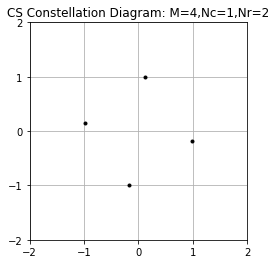

In [240]:
plot_constellation_diagram(all_one_hot_messages, transmitter2, f"M={M},Nc={Nc},Nr={Nr}")
# plt.savefig("./figures/qpsk_constellation_diagram.png")

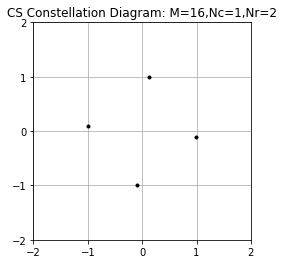

In [44]:
plot_constellation_diagram(all_one_hot_messages4, transmitter4, f"M={M},Nc={Nc4},Nr={Nr4}")
# plt.savefig("./figures/qpsk_constellation_diagram.png")

#### Autoencoder4 trained from fresh2
axis = 2, 10 epochs

In [72]:
print(f"M={M},Nc={Nc4},Nr={Nr4}")
print(transmitter4.predict(all_one_hot_messages4).shape)
#(M,Nc,2)
transmitter4.predict(all_one_hot_messages4)

M=4,Nc=1,Nr=2
(4, 1, 2)


array([[[-0.8381607 ,  0.5454234 ]],

       [[-0.0331063 ,  0.9994519 ]],

       [[ 0.83851695,  0.54487556]],

       [[ 0.9236054 , -0.3833446 ]]], dtype=float32)

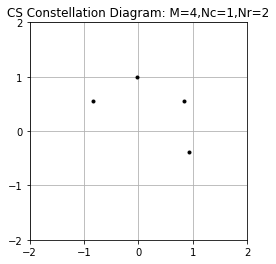

In [73]:
plot_constellation_diagram(all_one_hot_messages4, transmitter4, f"M={M},Nc={Nc4},Nr={Nr4}")
# plt.savefig("./figures/qpsk_constellation_diagram.png")

#### Autoencoder4 trained from fresh2
Same as above, but trained for 10 epochs (an extra 10)

In [75]:
print(f"M={M},Nc={Nc4},Nr={Nr4}")
print(transmitter4.predict(all_one_hot_messages4).shape)
#(M,Nc,2)
transmitter4.predict(all_one_hot_messages4)

M=4,Nc=1,Nr=2
(4, 1, 2)


array([[[-0.83112544,  0.556085  ]],

       [[ 0.02088728,  0.9997818 ]],

       [[ 0.785271  ,  0.61915225]],

       [[ 0.92870617, -0.37081653]]], dtype=float32)

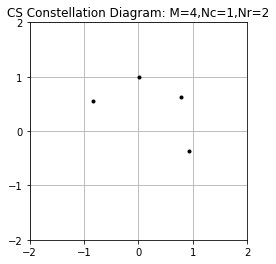

In [76]:
plot_constellation_diagram(all_one_hot_messages4, transmitter4, f"M={M},Nc={Nc4},Nr={Nr4}")
# plt.savefig("./figures/qpsk_constellation_diagram.png")

#### Autoencoder4 trained from fresh3
Same as above, but trained for 100 epochs (an extra 80)

In [78]:
print(f"M={M},Nc={Nc4},Nr={Nr4}")
print(transmitter4.predict(all_one_hot_messages4).shape)
#(M,Nc,2)
transmitter4.predict(all_one_hot_messages4)

M=4,Nc=1,Nr=2
(4, 1, 2)


array([[[-0.81807053,  0.5751178 ]],

       [[ 0.05629861,  0.998414  ]],

       [[ 0.87932265,  0.47622645]],

       [[ 0.88242936, -0.47044495]]], dtype=float32)

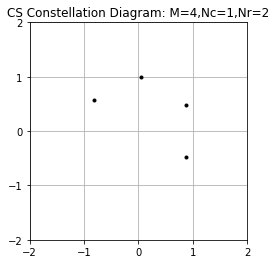

In [79]:
plot_constellation_diagram(all_one_hot_messages4, transmitter4, f"M={M},Nc={Nc4},Nr={Nr4}")
# plt.savefig("./figures/qpsk_constellation_diagram.png")

#### Autoencoder4adam
Trained over 10 epochs using an Adam optimiser as used in the paper

In [86]:
print(f"M={M},Nc={Nc4},Nr={Nr4}")
print(transmitter4adam.predict(all_one_hot_messages4).shape)
#(M,Nc,2)
transmitter4adam.predict(all_one_hot_messages4)

M=4,Nc=1,Nr=2
(4, 1, 2)


array([[[-0.99388415, -0.11042722]],

       [[ 0.45482168,  0.89058256]],

       [[ 0.6019942 , -0.79850054]],

       [[-0.99388415, -0.11042722]]], dtype=float32)

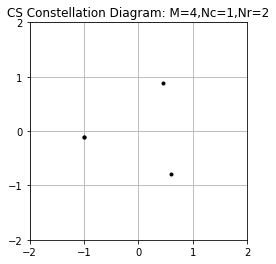

In [87]:
plot_constellation_diagram(all_one_hot_messages4, transmitter4adam, f"M={M},Nc={Nc4},Nr={Nr4}")
# plt.savefig("./figures/qpsk_constellation_diagram.png")

#### New training set, 1 epochs

In [71]:
print(f"M={M},Nc={Nc},Nr={Nr}")
print(transmitter.predict(all_one_hot_messages).shape)
#(M,Nc,2)
transmitter.predict(all_one_hot_messages)

M=4,Nc=1,Nr=2
(4, 1, 2)


array([[[ 0.08172178, -2.2294135 ]],

       [[-4.237483  , -3.2946773 ]],

       [[ 1.7539062 ,  2.044017  ]],

       [[-1.433624  ,  1.4104607 ]]], dtype=float32)

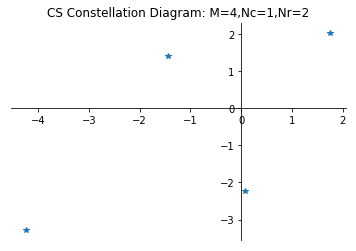

In [72]:
plot_constellation_diagram(all_one_hot_messages, f"M={M},Nc={Nc},Nr={Nr}")
# plt.savefig("./figures/wrong_constellation_diagram.png")

### 16-QAM Constellation Diagrams
#### Autoencoder16
10 epochs

In [263]:
print(f"M={M},Nc={Nc},Nr={Nr}")
print(transmitter16.predict(all_one_hot_messages16).shape)
#(M,Nc,2)
transmitter16.predict(all_one_hot_messages16)

M=16,Nc=1,Nr=2
(16, 1, 2)


array([[[-0.8166406 ,  0.5771466 ]],

       [[-0.8171146 ,  0.5764752 ]],

       [[-0.81698024,  0.57666564]],

       [[-0.81669366,  0.5770714 ]],

       [[-0.8170382 ,  0.5765834 ]],

       [[-0.81692266,  0.57674736]],

       [[-0.81657773,  0.57723564]],

       [[-0.8168798 ,  0.5768078 ]],

       [[-0.81660795,  0.5771928 ]],

       [[-0.81739414,  0.5760787 ]],

       [[-0.81669426,  0.57707053]],

       [[-0.8165637 ,  0.5772553 ]],

       [[-0.81745994,  0.5759855 ]],

       [[-0.8167853 ,  0.5769417 ]],

       [[-0.8165637 ,  0.5772553 ]],

       [[-0.8165637 ,  0.5772553 ]]], dtype=float32)

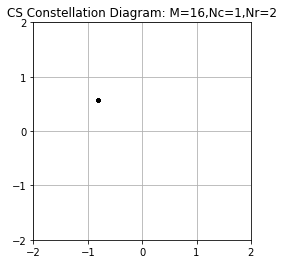

In [264]:
plot_constellation_diagram(all_one_hot_messages16, transmitter16, f"M={M},Nc={Nc},Nr={Nr}")
# plt.savefig("./figures/qpsk_constellation_diagram.png")

#### Autoencoder16
24 epochs, validation loss converged to 2.7728 and stopped decreasing. Interestingly the points are not exactly the same as they were when the QPSK case had inputs mapping to the same channel symbol

In [266]:
print(f"M={M},Nc={Nc},Nr={Nr}")
print(transmitter16.predict(all_one_hot_messages16).shape)
#(M,Nc,2)
transmitter16.predict(all_one_hot_messages16)

M=16,Nc=1,Nr=2
(16, 1, 2)


array([[[-0.816641  ,  0.577146  ]],

       [[-0.8171153 ,  0.57647425]],

       [[-0.81697845,  0.5766682 ]],

       [[-0.8166949 ,  0.5770695 ]],

       [[-0.81704015,  0.57658076]],

       [[-0.81692564,  0.5767431 ]],

       [[-0.8165782 ,  0.57723486]],

       [[-0.81688267,  0.5768038 ]],

       [[-0.81660825,  0.5771923 ]],

       [[-0.81739527,  0.57607704]],

       [[-0.81669563,  0.5770686 ]],

       [[-0.8165637 ,  0.5772553 ]],

       [[-0.8174593 ,  0.5759863 ]],

       [[-0.8167832 ,  0.57694477]],

       [[-0.8165637 ,  0.5772553 ]],

       [[-0.8165637 ,  0.5772553 ]]], dtype=float32)

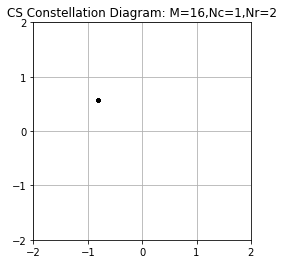

In [267]:
plot_constellation_diagram(all_one_hot_messages16, transmitter16, f"M={M},Nc={Nc},Nr={Nr}")
# plt.savefig("./figures/qpsk_constellation_diagram.png")

### New Leaky Relu Autoencoder 
##### Autoencoder2_2

M=4,Nc=1,Nr=2
(4, 1, 2)


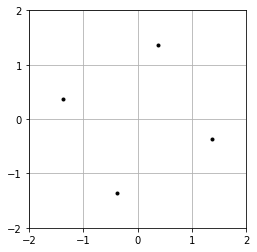

In [85]:
print(f"M={4},Nc={Nc2_2},Nr={Nr2_2}")
print(transmitter2_2.predict(all_one_hot_messages4).shape)
#(M,Nc,2)
transmitter2_2.predict(all_one_hot_messages4)

# The constellation diagram
plot_constellation_diagram(all_one_hot_messages4, transmitter2_2, f"M={M},Nc={Nc2_2},Nr={Nr2_2}")
# plt.savefig("./figures/leaky_relu_qpsk_constellation_diagram.png")

##### Autoencoder2_4

M=256,Nc=1,Nr=2
(16, 1, 2)


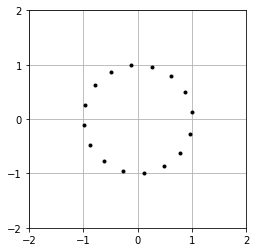

In [56]:
print(f"M={M},Nc={Nc2_4},Nr={Nr2_4}")
print(transmitter2_4.predict(all_one_hot_messages16).shape)
#(M,Nc,2)
transmitter2_4.predict(all_one_hot_messages16)

# The constellation diagram
plot_constellation_diagram(all_one_hot_messages16, transmitter2_4, f"M={M},Nc={Nc2_4},Nr={Nr2_4}")
# plt.savefig("./figures/leaky_relu_16_QAM_constellation_diagram.png")

##### Autoencoder7_4

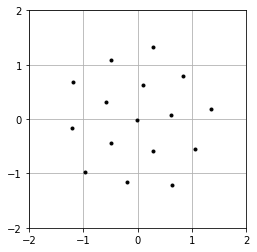

In [68]:
plot_tSNE_constellation_diagram(all_one_hot_messages16, transmitter7_4)
# plt.savefig("./figures/leaky_relu_7_4_constellation_diagram.png")

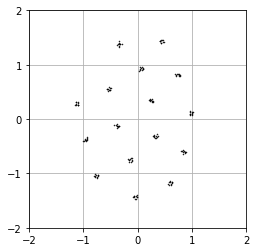

In [77]:
plot_noisy_tSNE_constellation_diagram(all_one_hot_messages16, channel_sym_with_noise7_4, 10, dot_size=1)
# plt.savefig("./figures/leaky_relu_7_4_constellation_diagram.png")

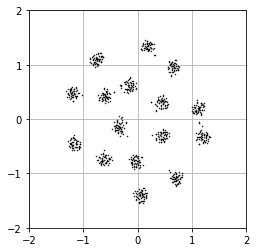

In [83]:
plot_noisy_tSNE_constellation_diagram(all_one_hot_messages16, transmitter7_4, 50)
# plt.savefig("./figures/leaky_relu_7_4_constellation_diagram_with_noise.png")

### Look at the output

In [88]:
# all_one_hot_messages4

In [87]:
# autoencoder2_2.predict(all_one_hot_messages4)

In [86]:
# autoencoder_symbs2_2.predict(all_one_hot_messages4)

In [85]:
# all_one_hot_messages16

In [84]:
# autoencoder2_4.predict(all_one_hot_messages16)

In [83]:
# autoencoder_symbs2_4.predict(all_one_hot_messages16)

### Assess performance across a range of SNRs
The O'Shea paper defined the variance of the noise to be $β = (2RE_b/N_0)^{−1}$

In [204]:
# (2,2)
t0 = time()
Eb_N0_dbs = np.arange(-4,8.5,0.5)
bler = np.empty(Eb_N0_dbs.size)
for i, ratio_db in enumerate(tqdm_notebook(Eb_N0_dbs, desc="1st loop")):
    print(f"ratio_db = {ratio_db}, i = {i}/{Eb_N0_dbs.size}", end="\r")
    ## Get noise std_dev 
    noise_std = get_noise_sigma(ratio_db, Rr=1)
    ## Make new model with loaded weights
    autoencoder_loaded, _, _, autoencoder_symbs_loaded, \
        _, _, _ \
        = make_model(M, R, noise_std, "relu")
    autoencoder_loaded.load_weights('second_qpsk_model.h5', by_name=True)
        
    ## Check Accuracy on test set
    pred_symbs = autoencoder_symbs_loaded.predict(test_data)
    bler[i] = get_block_error_rate(test_data, pred_symbs)
print(f"Took {time() - t0}")

Took 2131.674866437912/25


#### Get performance of (2,2) and (8,8) leaky relu models across range fo SNRs

In [87]:
# (2,2)
act_f = keras.layers.advanced_activations.LeakyReLU()
act_f.__name__ = 'leakyrelu'
t0 = time()
Eb_N0_dbs = np.arange(-4,8.5,0.5)
bler = np.empty(Eb_N0_dbs.size)
# for i, ratio_db in enumerate(tqdm_notebook(Eb_N0_dbs, desc="1st loop")):
for i, ratio_db in enumerate(Eb_N0_dbs):
    print(f"ratio_db = {ratio_db}, i = {i+1}/{Eb_N0_dbs.size}", end="\r")
    bler[i] = get_noise_bler(2**2, 2, ratio_db, \
                             './models/autoencoder_2_2_lr_scaled_cs_0.0045.h5', \
                             test_data4, act_f)
print(f"Took {time() - t0}")

/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Took 769.7926292419434


In [102]:
# (8,8)
t0 = time()
Eb_N0_dbs = np.arange(-4,8.5,0.5)
bler = np.empty(Eb_N0_dbs.size)
for i, ratio_db in enumerate(tqdm_notebook(Eb_N0_dbs, desc="1st loop")):
    print(f"ratio_db = {ratio_db}, i = {i+1}/{Eb_N0_dbs.size}", end="\r")
    bler[i] = get_noise_bler_k(2**8, 2, ratio_db, \
                             './models/autoencoder_8_8_leaky_relu0.0750.h5', \
                             test_data256, act_f)
print(f"Took {time() - t0}")

/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Took 128.75989055633545


In [76]:
# (7,4)
t0 = time()
Eb_N0_dbs = np.arange(-4,8.5,0.5)
bler = np.empty(Eb_N0_dbs.size)
# for i, ratio_db in enumerate(tqdm_notebook(Eb_N0_dbs, desc="1st loop")):
for i, ratio_db in enumerate(Eb_N0_dbs):
    print(f"ratio_db = {ratio_db}, i = {i+1}/{Eb_N0_dbs.size}", end="\r")
    bler[i] = get_non_complex_noise_bler(4, 7, ratio_db, \
                                         './models/autoencoder_7_4_leaky_relu0.8866.h5', \
                                         test_data16, act_f)
print(f"Took {time() - t0}")

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class

Took 1148.1060771942139


In [86]:
# (8,8) tapered, n layers
t0 = time()
Eb_N0_dbs = np.arange(-4,8.5,0.5)
bler = np.empty(Eb_N0_dbs.size)

hl_act_f = keras.layers.advanced_activations.LeakyReLU()
hl_act_f.__name__ = 'leakyrelu'

# for i, ratio_db in enumerate(tqdm_notebook(Eb_N0_dbs, desc="1st loop")):
for i, ratio_db in enumerate(Eb_N0_dbs):
    print(f"ratio_db = {ratio_db}, i = {i+1}/{Eb_N0_dbs.size}", end="\r")
    bler[i] = get_complex_tapered_noise_bler(2**8, 2, ratio_db, \
                                             './models/autoencoder8_8_tap_2l0.1763.h5', \
                                             test_data256, hl_act_f, \
                                             "tanh", 2)
print(f"Took {time() - t0}")

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Took 1685.7993321418762


In [88]:
# ## Save
# leaky_relu_autoencoder_2_2_bler = bler
# np.save('./key_results/leaky_relu_autoencoder_2_2_bler.npy', leaky_relu_autoencoder_2_2_bler)

# leaky_relu_autoencoder_2_2_bler_0_0683_Rr1 = bler
# np.save('./key_results/leaky_relu_autoencoder_2_2_bler_0_0683_Rr1.npy', leaky_relu_autoencoder_2_2_bler_0_0683_Rr1)

# lr_autoencoder_2_2_bler_0_0047_Rr1_scaled = bler
# np.save('./key_results/lr_autoencoder_2_2_bler_0_0047_Rr1_scaled.npy', lr_autoencoder_2_2_bler_0_0047_Rr1_scaled)

# leaky_relu_autoencoder_2_2_bler_new_EbN0 = bler
# leaky_relu_autoencoder_8_8_bler_new_EbN0 = bler

# leaky_relu_autoencoder_2_2_bler_k = blertion layers should be used just like any other layer in a model.
# np.save('./key_results/leaky_relu_autoencoder_2_2_bler_k.npy', leaky_relu_autoencoder_2_2_bler_k)

# leaky_relu_autoencoder_8_8_bler_k = bler
# np.save('./key_results/leaky_relu_autoencoder_8_8_bler_k.npy', leaky_relu_autoencoder_8_8_bler_k)

# leaky_relu_autoencoder_7_4_bler_k = bler
# np.save('./key_results/leaky_relu_autoencoder_7_4_bler_k.npy', leaky_relu_autoencoder_7_4_bler_k)

# leaky_relu_autoencoder_7_4_bler_Rr4_7 = bler
# np.save('./key_results/leaky_relu_autoencoder_7_4_bler_Rr4_7.npy', leaky_relu_autoencoder_7_4_bler_Rr4_7)

# leaky_relu_autoencoder_8_8_bler = bler
# np.save('./key_results/leaky_relu_autoencoder_8_8_bler.npy', leaky_relu_autoencoder_8_8_bler)

# leaky_relu_autoencoder_8_8_bler_2l_0_1763Rr1 = bler
# np.save('./key_results/leaky_relu_autoencoder_8_8_bler_2l_0_1763Rr1.npy', leaky_relu_autoencoder_8_8_bler_2l_0_1763Rr1)

# leaky_relu_autoencoder_7_4_bler = bler
# np.save('./key_results/leaky_relu_autoencoder_7_4_bler.npy', leaky_relu_autoencoder_7_4_bler)

# leaky_relu_autoencoder_7_4_bler0_8866_Rr4_7 = bler
# np.save('./key_results/leaky_relu_autoencoder_7_4_bler0_8866_Rr4_7.npy', leaky_relu_autoencoder_7_4_bler0_8866_Rr4_7)

## Load
leaky_relu_autoencoder_2_2_bler = np.load('./key_results/leaky_relu_autoencoder_2_2_bler.npy')
leaky_relu_autoencoder_8_8_bler = np.load('./key_results/leaky_relu_autoencoder_8_8_bler.npy')
leaky_relu_autoencoder_7_4_bler = np.load('./key_results/leaky_relu_autoencoder_7_4_bler.npy')

leaky_relu_autoencoder_2_2_bler_k = np.load('./key_results/leaky_relu_autoencoder_2_2_bler_k.npy')
leaky_relu_autoencoder_8_8_bler_k = np.load('./key_results/leaky_relu_autoencoder_8_8_bler_k.npy')
leaky_relu_autoencoder_7_4_bler_k = np.load('./key_results/leaky_relu_autoencoder_7_4_bler_k.npy')


leaky_relu_autoencoder_7_4_bler_Rr4_7 = np.load('./key_results/leaky_relu_autoencoder_7_4_bler_Rr4_7.npy')
leaky_relu_autoencoder_7_4_bler0_8866_Rr4_7 = np.load('./key_results/leaky_relu_autoencoder_7_4_bler0_8866_Rr4_7.npy')
leaky_relu_autoencoder_8_8_bler_2l_0_1763Rr1 = np.load('./key_results/leaky_relu_autoencoder_8_8_bler_2l_0_1763Rr1.npy')
leaky_relu_autoencoder_2_2_bler_0_0683_Rr1 = np.load('./key_results/leaky_relu_autoencoder_2_2_bler_0_0683_Rr1.npy')

lr_autoencoder_2_2_bler_0_0047_Rr1_scaled = np.load('./key_results/lr_autoencoder_2_2_bler_0_0047_Rr1_scaled.npy')

In [57]:
# autoencoder8_8_tap_2l_bler = bler
# np.save('./key_results/autoencoder8_8_tap_2l_bler.npy', autoencoder8_8_tap_2l_bler)

# autoencoder8_8_tap_3l_bler = bler
# np.save('./key_results/autoencoder8_8_tap_3l_bler.npy', autoencoder8_8_tap_3l_bler)

# autoencoder8_8_tap_4l_bler = bler
# np.save('./key_results/autoencoder8_8_tap_4l_bler.npy', autoencoder8_8_tap_4l_bler)

# autoencoder8_8_tap_5l_bler = bler
# np.save('./key_results/autoencoder8_8_tap_5l_bler.npy', autoencoder8_8_tap_5l_bler)

autoencoder8_8_tap_2l_bler = np.load('./key_results/autoencoder8_8_tap_2l_bler.npy')
autoencoder8_8_tap_3l_bler = np.load('./key_results/autoencoder8_8_tap_3l_bler.npy')
autoencoder8_8_tap_4l_bler = np.load('./key_results/autoencoder8_8_tap_4l_bler.npy')
autoencoder8_8_tap_5l_bler = np.load('./key_results/autoencoder8_8_tap_5l_bler.npy')

### Plot results

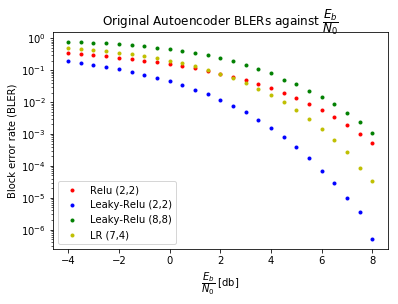

In [58]:
# ## Save
# autoencoder_2_2_bler = bler
# np.save('./key_results/autoencoder_2_2_bler.npy', autoencoder_2_2_bler)
## Load
Eb_N0_dbs = np.arange(-4,8.5,0.5)
autoencoder_2_2_bler = np.load('./key_results/autoencoder_2_2_bler.npy')

# Plot
plt.semilogy(Eb_N0_dbs, autoencoder_2_2_bler, 'r.')
plt.semilogy(Eb_N0_dbs, leaky_relu_autoencoder_2_2_bler, 'b.')
plt.semilogy(Eb_N0_dbs, leaky_relu_autoencoder_8_8_bler, 'g.')
plt.semilogy(Eb_N0_dbs, leaky_relu_autoencoder_7_4_bler, 'y.')
plt.title(r'Original Autoencoder BLERs against $\dfrac{E_b}{N_0}$')
plt.xlabel(r'$\dfrac{E_b}{N_0}$ [db]')
plt.ylabel("Block error rate (BLER)")
plt.legend(["Relu (2,2)", "Leaky-Relu (2,2)", "Leaky-Relu (8,8)", \
            "LR (7,4)"])
plt.show()
# plt.savefig("./figures/autoencoder_2_2_bler_EbNo_leaky_vs_relu.png")

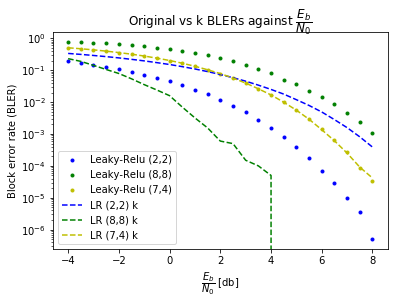

In [60]:
# ## Save
# autoencoder_2_2_bler = bler
# np.save('./key_results/autoencoder_2_2_bler.npy', autoencoder_2_2_bler)
## Load
Eb_N0_dbs = np.arange(-4,8.5,0.5)
autoencoder_2_2_bler = np.load('./key_results/autoencoder_2_2_bler.npy')

# Plot
plt.semilogy(Eb_N0_dbs, leaky_relu_autoencoder_2_2_bler, 'b.')
plt.semilogy(Eb_N0_dbs, leaky_relu_autoencoder_8_8_bler, 'g.')
plt.semilogy(Eb_N0_dbs, leaky_relu_autoencoder_7_4_bler, 'y.')
plt.semilogy(Eb_N0_dbs, leaky_relu_autoencoder_2_2_bler_k, 'b--')
plt.semilogy(Eb_N0_dbs, leaky_relu_autoencoder_8_8_bler_k, 'g--')
plt.semilogy(Eb_N0_dbs, leaky_relu_autoencoder_7_4_bler_k, 'y--')
plt.title(r'Original vs k BLERs against $\dfrac{E_b}{N_0}$')
plt.xlabel(r'$\dfrac{E_b}{N_0}$ [db]')
plt.ylabel("Block error rate (BLER)")
plt.legend(["Leaky-Relu (2,2)", "Leaky-Relu (8,8)", \
            "Leaky-Relu (7,4)", \
            "LR (2,2) k", "LR (8,8) k", "LR (7,4) k"])
plt.show()
# plt.savefig("./figures/autoencoder_2_2_bler_EbNo_leaky_vs_relu.png")

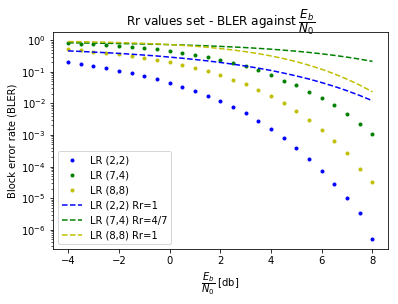

In [65]:
# All with updated correct R values.
plt.semilogy(Eb_N0_dbs, leaky_relu_autoencoder_2_2_bler, 'b.')
plt.semilogy(Eb_N0_dbs, leaky_relu_autoencoder_8_8_bler, 'g.')
plt.semilogy(Eb_N0_dbs, leaky_relu_autoencoder_7_4_bler, 'y.')
plt.semilogy(Eb_N0_dbs, leaky_relu_autoencoder_2_2_bler_0_0683_Rr1, 'b--')
plt.semilogy(Eb_N0_dbs, leaky_relu_autoencoder_7_4_bler0_8866_Rr4_7, 'g--')
plt.semilogy(Eb_N0_dbs, leaky_relu_autoencoder_8_8_bler_2l_0_1763Rr1, 'y--')

plt.title(r'Rr values set - BLER against $\dfrac{E_b}{N_0}$')
plt.xlabel(r'$\dfrac{E_b}{N_0}$ [db]')
plt.ylabel("Block error rate (BLER)")
plt.legend(["LR (2,2)", "LR (7,4)", "LR (8,8)", \
            "LR (2,2) Rr=1", "LR (7,4) Rr=4/7", "LR (8,8) Rr=1"])
plt.show()
# plt.savefig("./figures/autoencoder_2_2_bler_EbNo.png")

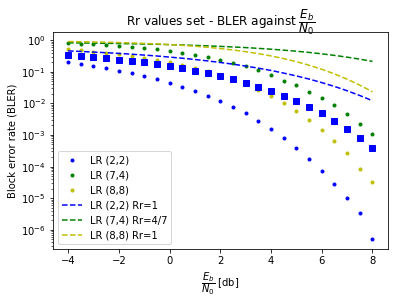

In [89]:
# All with updated correct R values.
plt.semilogy(Eb_N0_dbs, leaky_relu_autoencoder_2_2_bler, 'b.')
plt.semilogy(Eb_N0_dbs, leaky_relu_autoencoder_8_8_bler, 'g.')
plt.semilogy(Eb_N0_dbs, leaky_relu_autoencoder_7_4_bler, 'y.')
plt.semilogy(Eb_N0_dbs, leaky_relu_autoencoder_2_2_bler_0_0683_Rr1, 'b--')
plt.semilogy(Eb_N0_dbs, leaky_relu_autoencoder_7_4_bler0_8866_Rr4_7, 'g--')
plt.semilogy(Eb_N0_dbs, leaky_relu_autoencoder_8_8_bler_2l_0_1763Rr1, 'y--')
plt.semilogy(Eb_N0_dbs, lr_autoencoder_2_2_bler_0_0047_Rr1_scaled, 'bs')
plt.title(r'Rr values set - BLER against $\dfrac{E_b}{N_0}$')
plt.xlabel(r'$\dfrac{E_b}{N_0}$ [db]')
plt.ylabel("Block error rate (BLER)")
plt.legend(["LR (2,2)", "LR (7,4)", "LR (8,8)", \
            "LR (2,2) Rr=1", "LR (7,4) Rr=4/7", "LR (8,8) Rr=1"])
plt.show()
# plt.savefig("./figures/autoencoder_2_2_bler_EbNo.png")

##### Comparing numbers of layers for (8,8)

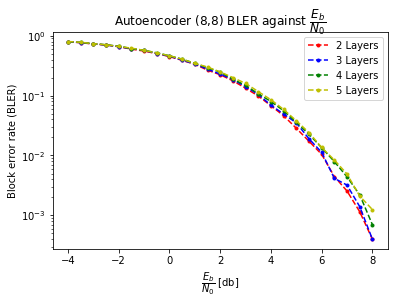

In [55]:
plt.semilogy(Eb_N0_dbs, autoencoder8_8_tap_2l_bler, 'r.--')
plt.semilogy(Eb_N0_dbs, autoencoder8_8_tap_3l_bler, 'b.--')
plt.semilogy(Eb_N0_dbs, autoencoder8_8_tap_4l_bler, 'g.--')
plt.semilogy(Eb_N0_dbs, autoencoder8_8_tap_5l_bler, 'y.--')
plt.title(r'Autoencoder (8,8) BLER against $\dfrac{E_b}{N_0}$')
plt.xlabel(r'$\dfrac{E_b}{N_0}$ [db]')
plt.ylabel("Block error rate (BLER)")
plt.legend(["2 Layers", "3 Layers", "4 Layers", "5 Layers"])
plt.show()
# plt.savefig("./figures/autoencoder_8_8_bler_EbNo_2-5_layers.png")

From the above graph we can see that adding more layers just reduces the performance of the autoencoder. This implies the best number of layers is 2.

### Implementing Uncoded BPSK

 would be good to use this in the presentation
 https://en.wikipedia.org/wiki/Phase-shift_keying
 
 ##### Uncoded BPSK (2,2)

In [63]:
# (2,2)
t0 = time()
Eb_N0_dbs = np.arange(-4,8.5,0.5)
bler_bpsk = np.empty(Eb_N0_dbs.size)
for i, ratio_db in enumerate(tqdm_notebook(Eb_N0_dbs, desc="1st loop")):
#     print(f"ratio_db = {ratio_db}, i = {i}/{Eb_N0_dbs.size}")
    ## Get noise std_dev 
    noise_std = get_noise_sigma(ratio_db, Rr=1)
    # Encode, add noise and decode data, then get BLER
    bler_bpsk[i] = bpsk_get_bler(noise_std, test_data4)
print(f"Took {time() - t0}")

Took 132.86356496810913


In [66]:
# (4,4)
t0 = time()
Eb_N0_dbs = np.arange(-4,8.5,0.5)
bler_bpsk = np.empty(Eb_N0_dbs.size)
for i, ratio_db in enumerate(tqdm_notebook(Eb_N0_dbs, desc="1st loop")):
#     print(f"ratio_db = {ratio_db}, i = {i}/{Eb_N0_dbs.size}")
    ## Get noise std_dev 
    noise_std = get_noise_sigma(ratio_db, Rr=1)
    # Encode, add noise and decode data, then get BLER
    bler_bpsk[i] = bpsk_get_bler(noise_std, test_data16)
print(f"Took {time() - t0}")

Took 477.8880424499512


In [69]:
# (8,8)
t0 = time()
Eb_N0_dbs = np.arange(-4,8.5,0.5)
bler_bpsk = np.empty(Eb_N0_dbs.size)
for i, ratio_db in enumerate(tqdm_notebook(Eb_N0_dbs, desc="1st loop")):
#     print(f"ratio_db = {ratio_db}, i = {i}/{Eb_N0_dbs.size}")
    ## Get noise std_dev 
    noise_std = get_noise_sigma(ratio_db, Rr=1)
    # Encode, add noise and decode data, then get BLER
    bler_bpsk[i] = bpsk_get_bler(noise_std, test_data256)
print(f"Took {time() - t0}")

Took 77.36253523826599


##### Uncoded BPSK (8,8)

In [101]:
# ## Save
# Original data

# bpsk_2_2_bler = bler_bpsk
# np.save('./key_results/bpsk_2_2_bler.npy', bpsk_2_2_bler)

# bpsk_4_4_bler = bler_bpsk
# np.save('./key_results/bpsk_4_4_bler.npy', bpsk_4_4_bler_new)

# bpsk_8_8_bler = bler_bpsk
# np.save('./key_results/bpsk_8_8_bler.npy', bpsk_8_8_bler)

# Rr = 1
# bpsk_2_2_bler_Rr1 = bler_bpsk
# np.save('./key_results/bpsk_2_2_bler_Rr1.npy', bpsk_2_2_bler_Rr1)

# bpsk_4_4_bler_Rr1 = bler_bpsk
# np.save('./key_results/bpsk_4_4_bler_Rr1.npy', bpsk_4_4_bler_Rr1)

# bpsk_8_8_bler_Rr1 = bler_bpsk
# np.save('./key_results/bpsk_8_8_bler_Rr1.npy', bpsk_8_8_bler_Rr1)


# ## Load
bpsk_2_2_bler = np.load('./key_results/bpsk_2_2_bler.npy')
bpsk_4_4_bler = np.load('./key_results/bpsk_4_4_bler.npy')
bpsk_8_8_bler = np.load('./key_results/bpsk_8_8_bler.npy')

bpsk_2_2_bler_Rr1 = np.load('./key_results/bpsk_2_2_bler_Rr1.npy')
bpsk_4_4_bler_Rr1 = np.load('./key_results/bpsk_4_4_bler_Rr1.npy')
bpsk_8_8_bler_Rr1 = np.load('./key_results/bpsk_8_8_bler_Rr1.npy')

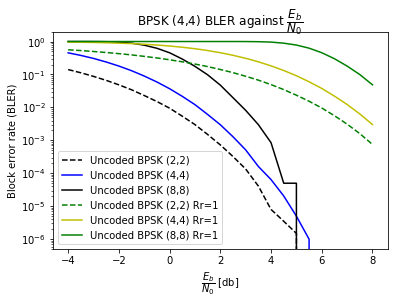

In [71]:
plt.semilogy(Eb_N0_dbs, bpsk_2_2_bler, 'k--')
plt.semilogy(Eb_N0_dbs, bpsk_4_4_bler, 'b-')
plt.semilogy(Eb_N0_dbs, bpsk_8_8_bler, 'k-')
plt.semilogy(Eb_N0_dbs, bpsk_2_2_bler_Rr1, 'g--')
plt.semilogy(Eb_N0_dbs, bpsk_4_4_bler_Rr1, 'y-')
plt.semilogy(Eb_N0_dbs, bpsk_8_8_bler_Rr1, 'g-')

plt.title(r'BPSK (4,4) BLER against $\dfrac{E_b}{N_0}$')
plt.xlabel(r'$\dfrac{E_b}{N_0}$ [db]')
plt.ylabel("Block error rate (BLER)")
plt.legend(["Uncoded BPSK (2,2)", "Uncoded BPSK (4,4)", \
            "Uncoded BPSK (8,8)", "Uncoded BPSK (2,2) Rr=1", \
            "Uncoded BPSK (4,4) Rr=1", "Uncoded BPSK (8,8) Rr=1"])
plt.show()
# plt.savefig("./figures/autoencoder_2_2_bler_EbNo.png")

### Implementing Hamming Hard Decision Encoded BPSK

http://www.dsplog.com/2009/09/29/hamming-74-code-with-hard-decision-decoding/ 

<br>
http://www.dsplog.com/2009/01/04/viterbi/

<br>

http://www.dsplog.com/2012/03/15/hamming-code-soft-hard-decode/

In [70]:
t0 = time()
std = 0
# Encode the one_hot_encoded_vectors into bits
test_data_enc = hamming_7_4_encode(test_data4, G)   
# add noise
noise = std * np.random.randn(test_data_enc.shape[0],\
                              test_data_enc.shape[1])
r = test_data_enc + noise
# Do error correction and decode message
corrected_message = hamming_7_4_decode_and_correct(r, H,\
                                                   R_ham)
# Get Block error rate
bler = get_block_error_rate(test_data4, corrected_message)
all_true = (corrected_message == test_data4).all()
print("bler = ", bler)
print("all_true = ", all_true)
print(f"Took {time()-t0}s")

bler =  0.0
all_true =  True
Took 36.734904527664185s


In [71]:
t0 = time()
std = 0.22
# Encode the one_hot_encoded_vectors into bits
test_data_enc = hamming_7_4_encode(test_data4, G)   
# add noise
noise = std * np.random.randn(test_data_enc.shape[0],\
                              test_data_enc.shape[1])
r = test_data_enc + noise
# Do error correction and decode message
corrected_message = hamming_7_4_decode_and_correct(r, H,\
                                                   R_ham)
# Get Block error rate
bler = get_block_error_rate(test_data4, corrected_message)
all_true = (corrected_message == test_data4).all()
print("bler = ", bler)
print("all_true = ", all_true)
print(f"Took {time()-t0}s")

bler =  0.024102
all_true =  False
Took 34.793314933776855s


In [80]:
t0 = time()
# Eb_N0_dbs = np.arange(-4,-2,0.5)
Eb_N0_dbs = np.arange(-4,8.5,0.5)
bler_hamming_HD = np.empty(Eb_N0_dbs.size)
for i, ratio_db in enumerate(tqdm_notebook(Eb_N0_dbs, desc="1st loop")):
    print(f"ratio_db = {ratio_db}, i = {i}/{Eb_N0_dbs.size}", end="\r")
    ## Get noise std_dev 
    noise_std = get_noise_sigma(ratio_db, Rr=4/7)
    ## Transmit Hamming encoded and BPSK
    test_data_enc = hamming_7_4_encode(test_data4, G) 
    bpsk_encoded = bpsk_encode_vec(test_data_enc)
    # Add AWGN noise
    noise = noise_std * np.random.randn(bpsk_encoded.shape[0],\
                                        bpsk_encoded.shape[1])
    received = bpsk_encoded + noise
    # Decode using BPSK
    bpsk_decoded = bpsk_decode_vec(received)

    # Decode using BPSK
    corrected_message = hamming_7_4_decode_and_correct(bpsk_decoded, H,\
                                                       R_ham)
    # Check Accuracy on test set
    bler_hamming_HD[i] = get_block_error_rate(test_data4, corrected_message)
print(f"Took {time() - t0}")

Took 1127.330214500427225


In [81]:
# ## Save
# hamming_7_4_HD_bler = bler_hamming_HD
# np.save('./key_results/hamming_7_4_HD_bler.npy', hamming_7_4_HD_bler)

# hamming_7_4_HD_bler_Rr4_7 = bler_hamming_HD
# np.save('./key_results/hamming_7_4_HD_bler_Rr4_7.npy', hamming_7_4_HD_bler_Rr4_7)

# ## Load
hamming_7_4_HD_bler = np.load('./key_results/hamming_7_4_HD_bler.npy')
hamming_7_4_HD_bler_Rr4_7 = np.load('./key_results/hamming_7_4_HD_bler_Rr4_7.npy')

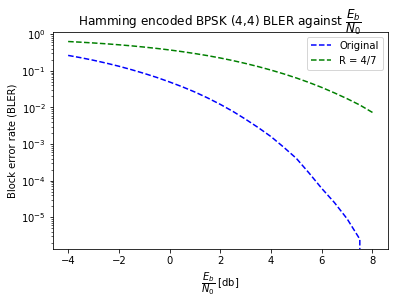

In [82]:
plt.semilogy(Eb_N0_dbs, hamming_7_4_HD_bler, 'b--')
plt.semilogy(Eb_N0_dbs, hamming_7_4_HD_bler_Rr4_7, 'g--')
plt.title(r'Hamming encoded BPSK (4,4) BLER against $\dfrac{E_b}{N_0}$')
plt.xlabel(r'$\dfrac{E_b}{N_0}$ [db]')
plt.ylabel("Block error rate (BLER)")
plt.legend(["Original", "R = 4/7"])
plt.show()
# plt.savefig("./figures/autoencoder_2_2_bler_EbNo.png")

### Hamming Encoding with MLD

In [80]:
tmp = np.vstack([all_one_hot_messages4,all_one_hot_messages4])
tmp.shape

(8, 4)

In [77]:
np.matmul(G,all_one_hot_messages4.T)

array([[1., 1., 0., 1.],
       [1., 0., 1., 1.],
       [1., 0., 0., 0.],
       [0., 1., 1., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [82]:
hamming_7_4_encode(tmp, G).shape

(7, 8)

### Comparison of Hamming, BPSK and autoencoder systems

##### O'Shea Figure 3a

In [106]:
# Load three sets of results
# bpsk_4_4_bler = np.load('./key_results/bpsk_4_4_bler.npy')
bpsk_4_4_bler_Rr1 = np.load('./key_results/bpsk_4_4_bler_Rr1.npy')
# hamming_7_4_HD_bler = np.load('./key_results/hamming_7_4_HD_bler.npy')
hamming_7_4_HD_bler_Rr4_7 = np.load('./key_results/hamming_7_4_HD_bler_Rr4_7.npy')
leaky_relu_autoencoder_7_4_bler = np.load('./key_results/leaky_relu_autoencoder_7_4_bler.npy')

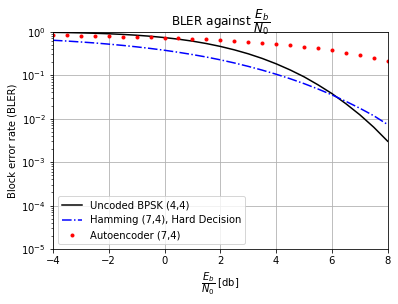

In [107]:
# Uncoded BPSK (4,4)
# Hamming (7,4) Hard Decision
# Autoencoder (7,4)
# Hamming (7,4) MLD

plt.semilogy(Eb_N0_dbs, bpsk_4_4_bler_Rr1, 'k-')
plt.semilogy(Eb_N0_dbs, hamming_7_4_HD_bler_Rr4_7, 'b-.')
plt.semilogy(Eb_N0_dbs, leaky_relu_autoencoder_7_4_bler0_8866_Rr4_7, 'r.')
plt.title(r'BLER against $\dfrac{E_b}{N_0}$')
plt.xlabel(r'$\dfrac{E_b}{N_0}$ [db]')
plt.ylabel("Block error rate (BLER)")
plt.legend(['Uncoded BPSK (4,4)', 'Hamming (7,4), Hard Decision', \
            'Autoencoder (7,4)'],\
           loc="lower left")
plt.grid(True)
plt.axis([-4, 8, 1e-5, 1])
plt.show()
# plt.savefig("./figures/bler_vs_eb_only_three.png")

##### O'Shea Figure 3b

In [104]:
# Load three sets of results
# bpsk_2_2_bler = np.load('./key_results/bpsk_2_2_bler.npy')
# bpsk_8_8_bler = np.load('./key_results/bpsk_8_8_bler.npy')
bpsk_2_2_bler_Rr1 = np.load('./key_results/bpsk_2_2_bler_Rr1.npy')
bpsk_8_8_bler_Rr1 = np.load('./key_results/bpsk_8_8_bler_Rr1.npy')

leaky_relu_autoencoder_2_2_bler = np.load('./key_results/leaky_relu_autoencoder_2_2_bler.npy')
leaky_relu_autoencoder_8_8_bler = np.load('./key_results/leaky_relu_autoencoder_8_8_bler.npy')

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_base.py:2575: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  self.apply_aspect()
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_base.py:4371: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  self.apply_aspect()
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_base.py:4371: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  self.apply_aspect()
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_base.py:848: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  self.apply_aspect()


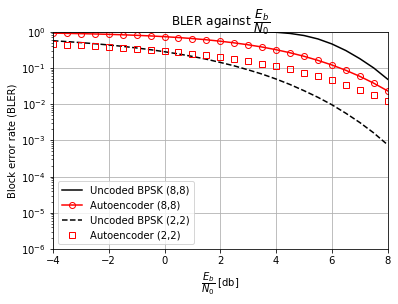

In [105]:
fig, ax = plt.subplots()
ax.semilogy(Eb_N0_dbs, bpsk_8_8_bler_Rr1, 'k-')
ax.semilogy(Eb_N0_dbs, leaky_relu_autoencoder_8_8_bler_2l_0_1763, \
            'ro-', markerfacecolor='none')
ax.semilogy(Eb_N0_dbs, bpsk_2_2_bler_Rr1, 'k--')
ax.semilogy(Eb_N0_dbs, leaky_relu_autoencoder_2_2_bler_0_0683_Rr1, \
            'rs', markerfacecolor='none')
ax.set_title(r'BLER against $\dfrac{E_b}{N_0}$')
ax.set_xlabel(r'$\dfrac{E_b}{N_0}$ [db]')
ax.set_ylabel("Block error rate (BLER)")
ax.grid(True)
ax.set_aspect('equal', 'box')
plt.legend(['Uncoded BPSK (8,8)', 'Autoencoder (8,8)',\
            'Uncoded BPSK (2,2)', 'Autoencoder (2,2)'], loc="lower left")
plt.axis([-4, 8, 1e-6, 1])
plt.show()
# ax.savefig("./figures/bler_vs_eb_only_three.png")

Clearly at the moment I need to fix a few things:
- Autoencoder (8,8) isn't doing well enough.
- I need to have a bigger data set for test_data256 so I have a smoother line at error rates of 10^-5.
- Need to work out why my BPSK is doing better than the one in the paper.

## Sweeping across different activation functions

- Tanh - ~linear for small inputs
- Relu - captures non linearity well
- Sigmoid, softmax, linear
- Inception learning

In [ ]:
# M = 4 # Number of one hot encoded messages
# R = 2 # R = k/n

# sigma = get_noise_sigma(7, R)
# print("sigma = ",sigma)
# all_one_hot_messagesTmp = np.diag(np.ones(M))
# autoencoderTmp, transmitterTmp, recieverTmp, autoencoder_symbsTmp, kTmp, NcTmp, NrTmp = make_model(M, R, sigma, "relu")

# # Fit the model
# autoencoderTmp.fit(train_data4, train_data4,
#                 epochs=2,
#                 batch_size=1000*M,
#                 shuffle=True,
#                 validation_data=(valid_data4,
#                                  valid_data4))
# # Get the test BLER
# pred_symbs_tmp = autoencoder_symbsTmp.predict(test_data4)
# bler_tmp = get_block_error_rate(test_data4, pred_symbs_tmp)
# print("bler_tmp = ", bler_tmp)

In [89]:
# Initialise data structures
# activation_funcs = ["relu", "tanh", "sigmoid", "linear", "softmax"]
activation_funcs = ["leaky_relu","tanh"]
# activation_func_sweep_results = {"relu":[], "tanh":[], "sigmoid":[], "linear": [], "softmax":[], "leaky_relu":[]}
activation_func_sweep_results = {"relu":[], "tanh":[], "sigmoid":[], "linear": [], 
                                 "softmax":[{},{},{},{},{},{},{},{}], "leaky_relu":[]}

# Initialise Variables
M = 4 # Number of one hot encoded messages
R = 2 # R = k/n
sigma = get_noise_sigma(7, R)
print("sigma = ",sigma)
all_one_hot_messagesTmp = np.diag(np.ones(M))

for act_f in activation_funcs:
    print("\n\nact_f = ", act_f)
    for i in range(10):
        print("\ni = ", i)
        
        if(act_f == "leaky_relu"):
            input_act = keras.layers.advanced_activations.LeakyReLU()
        else:
            input_act = act_f
        
        # Make a model
        autoencoderTmp, transmitterTmp, recieverTmp,\
            autoencoder_symbsTmp, kTmp, NcTmp, NrTmp \
            = make_model(M, R, sigma, input_act)
        
        # Fit the model
        autoencoderTmp.fit(train_data4, train_data4,
                        epochs=5,
                        batch_size=1000*M,
                        shuffle=True,
                        validation_data=(valid_data4,
                                         valid_data4))
        # Append a dictionary to the list for this activation 
        # function
        activation_func_sweep_results[act_f].append({})
        # Get the test BLER
        pred_symbs_tmp = autoencoder_symbsTmp.predict(test_data4)
        bler_tmp = get_block_error_rate(test_data4, pred_symbs_tmp) 
        activation_func_sweep_results[act_f][i]["bler"] = bler_tmp
#         # Save the model
#         activation_func_sweep_results[act_f][i]["model"] = {}
#         activation_func_sweep_results[act_f][i]["model"]["autoencoder"] = autoencoderTmp
#         activation_func_sweep_results[act_f][i]["model"]["transmitter"] = transmitterTmp
#         activation_func_sweep_results[act_f][i]["model"]["autoencoder_symbs"] = autoencoder_symbsTmp
        # Save the constellation diagram
        const_diag = transmitterTmp.predict(all_one_hot_messagesTmp)
        activation_func_sweep_results[act_f][i]["const_diag"] = const_diag
#         # Save the models
#         auto_file_path = './models/activ_func_sweep/' + act_f + str(i) + "autoencoder"
#         autoencoderTmp.save(auto_file_path+".model")
#         autoencoderTmp.save_weights(auto_file_path+'.h5')
        
#         tx_file_path = './models/activ_func_sweep/' + act_f + str(i) + "transmitter"
#         transmitterTmp.save(tx_file_path+".model")
#         transmitterTmp.save_weights(tx_file_path+'.h5')
        
#         auto_symbs_file_path = './models/activ_func_sweep/' + act_f + str(i) + "autoencoder_symbs"
#         autoencoder_symbsTmp.save(auto_symbs_file_path+".model")
#         autoencoder_symbsTmp.save_weights(auto_symbs_file_path+'.h5')

sigma =  0.22334179607548157


act_f =  leaky_relu

i =  0


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Train on 7200000 samples, validate on 800000 samples
Epoch 1/5
7200000/7200000 [==============================] - 23s 3us/step - loss: 0.3564 - val_loss: 0.0422
Epoch 2/5
7200000/7200000 [==============================] - 22s 3us/step - loss: 0.0208 - val_loss: 0.0114
Epoch 3/5
7200000/7200000 [==============================] - 21s 3us/step - loss: 0.0086 - val_loss: 0.0065
Epoch 4/5
7200000/7200000 [==============================] - 23s 3us/step - loss: 0.0057 - val_loss: 0.0052
Epoch 5/5
7200000/7200000 [==============================] - 22s 3us/step - loss: 0.0049 - val_loss: 0.0048

i =  1


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Train on 7200000 samples, validate on 800000 samples
Epoch 1/5
7200000/7200000 [==============================] - 23s 3us/step - loss: 0.4023 - val_loss: 0.0340
Epoch 2/5
7200000/7200000 [==============================] - 23s 3us/step - loss: 0.0180 - val_loss: 0.0105
Epoch 3/5
7200000/7200000 [==============================] - 22s 3us/step - loss: 0.0080 - val_loss: 0.0065
Epoch 4/5
7200000/7200000 [==============================] - 20s 3us/step - loss: 0.0057 - val_loss: 0.0053
Epoch 5/5
7200000/7200000 [==============================] - 24s 3us/step - loss: 0.0050 - val_loss: 0.0047

i =  2


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Train on 7200000 samples, validate on 800000 samples
Epoch 1/5
7200000/7200000 [==============================] - 23s 3us/step - loss: 0.3726 - val_loss: 0.0314
Epoch 2/5
7200000/7200000 [==============================] - 22s 3us/step - loss: 0.0169 - val_loss: 0.0100
Epoch 3/5
7200000/7200000 [==============================] - 21s 3us/step - loss: 0.0077 - val_loss: 0.0063
Epoch 4/5
7200000/7200000 [==============================] - 21s 3us/step - loss: 0.0056 - val_loss: 0.0049
Epoch 5/5
7200000/7200000 [==============================] - 21s 3us/step - loss: 0.0049 - val_loss: 0.0047

i =  3


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Train on 7200000 samples, validate on 800000 samples
Epoch 1/5
7200000/7200000 [==============================] - 23s 3us/step - loss: 0.2901 - val_loss: 0.0320
Epoch 2/5
7200000/7200000 [==============================] - 21s 3us/step - loss: 0.0177 - val_loss: 0.0106
Epoch 3/5
7200000/7200000 [==============================] - 22s 3us/step - loss: 0.0081 - val_loss: 0.0066
Epoch 4/5
7200000/7200000 [==============================] - 21s 3us/step - loss: 0.0057 - val_loss: 0.0049
Epoch 5/5
7200000/7200000 [==============================] - 21s 3us/step - loss: 0.0049 - val_loss: 0.0047

i =  4


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Train on 7200000 samples, validate on 800000 samples
Epoch 1/5
7200000/7200000 [==============================] - 22s 3us/step - loss: 0.3623 - val_loss: 0.0290
Epoch 2/5
7200000/7200000 [==============================] - 22s 3us/step - loss: 0.0160 - val_loss: 0.0096
Epoch 3/5
7200000/7200000 [==============================] - 22s 3us/step - loss: 0.0077 - val_loss: 0.0061
Epoch 4/5
7200000/7200000 [==============================] - 21s 3us/step - loss: 0.0055 - val_loss: 0.0051
Epoch 5/5
7200000/7200000 [==============================] - 22s 3us/step - loss: 0.0048 - val_loss: 0.0046

i =  5


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Train on 7200000 samples, validate on 800000 samples
Epoch 1/5
7200000/7200000 [==============================] - 24s 3us/step - loss: 0.2703 - val_loss: 0.0320
Epoch 2/5
7200000/7200000 [==============================] - 21s 3us/step - loss: 0.0183 - val_loss: 0.0111
Epoch 3/5
7200000/7200000 [==============================] - 21s 3us/step - loss: 0.0085 - val_loss: 0.0067
Epoch 4/5
7200000/7200000 [==============================] - 24s 3us/step - loss: 0.0059 - val_loss: 0.0055
Epoch 5/5
7200000/7200000 [==============================] - 20s 3us/step - loss: 0.0049 - val_loss: 0.0048

i =  6


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Train on 7200000 samples, validate on 800000 samples
Epoch 1/5
7200000/7200000 [==============================] - 23s 3us/step - loss: 0.3671 - val_loss: 0.0407
Epoch 2/5
7200000/7200000 [==============================] - 21s 3us/step - loss: 0.0223 - val_loss: 0.0130
Epoch 3/5
7200000/7200000 [==============================] - 22s 3us/step - loss: 0.0095 - val_loss: 0.0074
Epoch 4/5
7200000/7200000 [==============================] - 23s 3us/step - loss: 0.0062 - val_loss: 0.0055
Epoch 5/5
7200000/7200000 [==============================] - 23s 3us/step - loss: 0.0050 - val_loss: 0.0048

i =  7


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Train on 7200000 samples, validate on 800000 samples
Epoch 1/5
7200000/7200000 [==============================] - 17s 2us/step - loss: 0.3045 - val_loss: 0.0310
Epoch 2/5
7200000/7200000 [==============================] - 14s 2us/step - loss: 0.0169 - val_loss: 0.0103
Epoch 3/5
7200000/7200000 [==============================] - 14s 2us/step - loss: 0.0078 - val_loss: 0.0063
Epoch 4/5
7200000/7200000 [==============================] - 14s 2us/step - loss: 0.0056 - val_loss: 0.0052
Epoch 5/5
7200000/7200000 [==============================] - 14s 2us/step - loss: 0.0049 - val_loss: 0.0046

i =  8


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Train on 7200000 samples, validate on 800000 samples
Epoch 1/5
7200000/7200000 [==============================] - 16s 2us/step - loss: 0.4320 - val_loss: 0.0375
Epoch 2/5
7200000/7200000 [==============================] - 14s 2us/step - loss: 0.0195 - val_loss: 0.0111
Epoch 3/5
7200000/7200000 [==============================] - 14s 2us/step - loss: 0.0084 - val_loss: 0.0067
Epoch 4/5
7200000/7200000 [==============================] - 14s 2us/step - loss: 0.0058 - val_loss: 0.0054
Epoch 5/5
7200000/7200000 [==============================] - 14s 2us/step - loss: 0.0049 - val_loss: 0.0049

i =  9


/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/apsw/.local/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Train on 7200000 samples, validate on 800000 samples
Epoch 1/5
7200000/7200000 [==============================] - 20s 3us/step - loss: 0.5139 - val_loss: 0.0965
Epoch 2/5
7200000/7200000 [==============================] - 16s 2us/step - loss: 0.0365 - val_loss: 0.0161
Epoch 3/5
7200000/7200000 [==============================] - 21s 3us/step - loss: 0.0112 - val_loss: 0.0080
Epoch 4/5
7200000/7200000 [==============================] - 16s 2us/step - loss: 0.0067 - val_loss: 0.0055
Epoch 5/5
7200000/7200000 [==============================] - 15s 2us/step - loss: 0.0052 - val_loss: 0.0045


act_f =  tanh

i =  0
Train on 7200000 samples, validate on 800000 samples
Epoch 1/5
7200000/7200000 [==============================] - 19s 3us/step - loss: 0.3689 - val_loss: 0.0460
Epoch 2/5
7200000/7200000 [==============================] - 16s 2us/step - loss: 0.0244 - val_loss: 0.0135
Epoch 3/5
7200000/7200000 [==============================] - 15s 2us/step - loss: 0.0097 - val_loss: 0.0071
Epoch 

In [91]:
af_blers_tmp = np.zeros((2,10))
af_const_diags_tmp = np.zeros((2,10,4,1,2))

for j, act_f in enumerate(["leaky_relu", "tanh"]):
    for i in range(10):
        af_blers_tmp[j,i] = activation_func_sweep_results[act_f][i]["bler"]
        af_const_diags_tmp[j,i,:,:,:] = activation_func_sweep_results[act_f][i]["const_diag"]

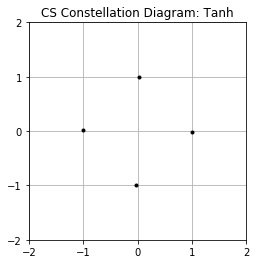

In [101]:
print("Means")
print(af_blers_tmp.mean(axis=1))
print("Mins")
print(af_blers_tmp.min(axis=1))

tmp = af_const_diags_tmp[0,0]
fig, ax = plt.subplots()
ax.plot(tmp[:,:,0], tmp[:,:,1],\
        'k.')
ax.set_title("CS Constellation Diagram: Tanh")
ax.set_aspect('equal', 'box')
plt.xticks([-2,-1,0,1,2])
plt.yticks([-2,-1,0,1,2])
plt.grid(True)

In [102]:
# np.save('./key_results/af_blers_tanh_vs_relu.npy', af_blers_tmp)
# np.save('./key_results/af_const_diags_tanh_vs_relu.npy', af_const_diags_tmp)

In [103]:
af_blers_tmp2 = np.load('./key_results/af_blers_tanh_vs_relu.npy')
af_const_diags_tmp2 = np.load('./key_results/af_const_diags_tanh_vs_relu.npy')

### Get the data from the models saved

In [106]:
# # Initialise data structures
# activation_funcs = ["relu", "tanh", "sigmoid", "linear", "softmax"]
# # activation_funcs = ["softmax"]
# activation_func_sweep_results = {"relu":[], "tanh":[], "sigmoid":[], "linear": [], "softmax":[], "leakyrelu":[]}
# af_blers = np.zeros((5,10))
# af_const_diags = np.zeros((5,10,4,1,2))

# # Initialise Variables
# M = 4 # Number of one hot encoded messages
# R = 2 # R = k/n
# sigma = get_noise_sigma(7, R)
# print("sigma = ",sigma)
# all_one_hot_messagesTmp = np.diag(np.ones(M))

# for j, act_f in enumerate(activation_funcs):
#     print("\nact_f = ", act_f)
#     #     for i in range(10):
#     for i in range(10):
#         print("i = ", i)
                
#         # Load a model's autoencoder, transmitter and 
#         # autoencoder_symbs
#         auto_file_path = './models/activ_func_sweep/' + act_f + str(i) + "autoencoder"
#         autoencoderTmp, transmitterTmp, recieverTmp, autoencoder_symbsTmp, kTmp, NcTmp, NrTmp = make_model(4, 2, sigma, act_f)
#         # autoencoder_loaded = load_model('first_qpsk_model.model')
#         autoencoderTmp.load_weights(auto_file_path+'.h5', by_name=True)
        
#         # Append a dictionary to the list for this activation 
#         # function
#         activation_func_sweep_results[act_f].append({})
#         # Get the test BLER
#         pred_symbs_tmp = autoencoder_symbsTmp.predict(test_data4)
#         bler_tmp = get_block_error_rate(test_data4, pred_symbs_tmp) 
#         activation_func_sweep_results[act_f][i]["bler"] = bler_tmp
#         af_blers[j,i] = bler_tmp
        
#         # Save the constellation diagram
#         const_diag = transmitterTmp.predict(all_one_hot_messagesTmp)
#         activation_func_sweep_results[act_f][i]["const_diag"] = const_diag
#         af_const_diags[j,i,:,:,:] = const_diag
        
#         # Save the models in the dictionary
#         activation_func_sweep_results[act_f][i]["model"] = {}
#         activation_func_sweep_results[act_f][i]["model"]["autoencoder"] = autoencoderTmp
#         activation_func_sweep_results[act_f][i]["model"]["transmitter"] = transmitterTmp
#         activation_func_sweep_results[act_f][i]["model"]["autoencoder_symbs"] = autoencoder_symbsTmp

#### Save the dictionary

In [64]:
# np.save('./key_results/af_blers.npy', af_blers)
# np.save('./key_results/af_const_diags.npy', af_const_diags)

### Plot the test errors for the five activation functions

In [51]:
af_blers = np.load('./key_results/af_blers.npy')
af_const_diags = np.load('./key_results/af_const_diags.npy')

np.mins
[0.0578365 0.0015135 0.294128  0.0015285 0.294504 ]
np.means
[0.55835335 0.00155635 0.29458565 0.00156515 0.4387    ]


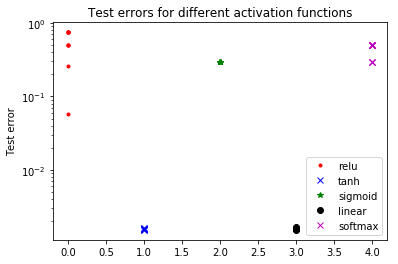

In [61]:
# MAYBE CHANGE TO A SEMILOGY GRAPH INSTEAD
plt.semilogy(np.zeros(10), af_blers[0,:], 'r.')
plt.semilogy(1*np.ones(10), af_blers[1,:], 'bx')
plt.semilogy(2*np.ones(10), af_blers[2,:], 'g*')
plt.semilogy(3*np.ones(10), af_blers[3,:], 'ko')
plt.semilogy(4*np.ones(10), af_blers[4,:], 'mx')
plt.title("Test errors for different activation functions")
plt.ylabel("Test error")
plt.legend(["relu", "tanh", "sigmoid", "linear", "softmax"], loc="lower right")
print("np.mins")
print(af_blers.min(axis=1))
print("np.means")
print(af_blers.mean(axis=1))
# plt.savefig("./figures/first_act_f_comparisson_logy.png")

Note that Tanh has the lowest bler out of all the activation functions, marginally ahead of linear. I want to check leaky relu as well though as that looked promising in the small amount of stuff I ran for it. As sen below the constellation diagrams look fine for Tanh and Linear below. Leaky relu is marginally better than tanh. Going to use tanh and Relu from now on.

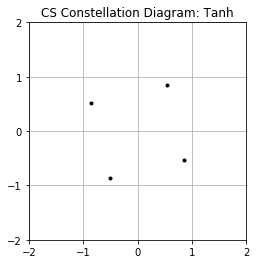

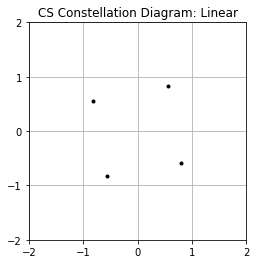

In [72]:
tanh_channel_symbols = af_const_diags[1,0,:,:,:]
linear_channel_symbols = af_const_diags[3,0,:,:,:]

fig, ax = plt.subplots()
ax.plot(tanh_channel_symbols[:,:,0], tanh_channel_symbols[:,:,1],\
        'k.')
ax.set_title("CS Constellation Diagram: Tanh")
ax.set_aspect('equal', 'box')
plt.xticks([-2,-1,0,1,2])
plt.yticks([-2,-1,0,1,2])
plt.grid(True)

fig, ax = plt.subplots()
ax.plot(linear_channel_symbols[:,:,0], linear_channel_symbols[:,:,1],\
        'k.')
ax.set_title("CS Constellation Diagram: Linear")
ax.set_aspect('equal', 'box')
plt.xticks([-2,-1,0,1,2])
plt.yticks([-2,-1,0,1,2])
plt.grid(True)

## Training two systems side by side

## RTN (Radio transfomer networks)
They found it consistently outperformed a normal autoencoder